<a href="https://colab.research.google.com/github/Nawa-Punabantu/Opt_Algos/blob/main/Opt_with_triangle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [74]:
import numpy as np
print(np.__version__)
import scipy as sp
print(sp.__version__)

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, Matern
from scipy.optimize import differential_evolution
from scipy.optimize import minimize, NonlinearConstraint

import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.integrate import solve_ivp
from scipy import integrate
import warnings


2.0.2
1.14.1


In [75]:
# smb model
# # tips:
    # - the Error: "IndexError: index 10 is out of bounds for axis 0 with size 9"
    # may be due to a miss-match in size between the initial conditons and c, q in the ode func.
# IMPORTING LIBRARIES
###########################################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
# Loading the Plotting Libraries
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
import matplotlib.animation as animation
# from PIL import Image
from scipy import integrate
# import plotly.graph_objects as go
import pandas as pd
import json
import os
import time
###########################################
# IMPORTING MY OWN FUNCTIONS
###########################################
# from post_pre_processing_funcs import

# INPUTS
#######################################################

# UNITS:
# All units must conform to:
# Time - s
# Lengths - cm^2
# Volumes - cm^3
# Masses - g
# Concentrations - g
# Volumetric flowrates - cm^3/s


def SMB(SMB_inputs):
    iso_type, Names, color, num_comp, nx_per_col, e, Pe_all, Bm, zone_config, L, d_col, d_in, t_index_min, n_num_cycles, Q_internal, parameter_sets = SMB_inputs[0:]

    ###################### (CALCUALTED) SECONDARY INPUTS #########################

    # Column Dimensions:
    ################################################################
    F = (1-e)/e     # Phase ratio
    t=0
    t_sets = 0
    Ncol_num = np.sum(zone_config) # Total number of columns
    L_total = L*Ncol_num # Total Lenght of all columns
    A_col = np.pi*0.25*d_col**2 # cm^2
    V_col = A_col * L # cm^3
    V_col_total = Ncol_num * V_col # cm^3
    A_in = np.pi * (d_in/2)**2 # cm^2
    alpha = A_in / A_col



    # Time Specs:
    ################################################################

    t_index = t_index_min*60 # s #

    # Notes:
    # - Cyclic Steady state typically happens only after 10 cycles (ref: https://doi.org/10.1205/026387603765444500)
    # - The system is not currently designed to account for periods of no external flow

    n_1_cycle = t_index * Ncol_num  # s How long a single cycle takes

    total_cycle_time = n_1_cycle*n_num_cycles # s

    tend = total_cycle_time # s # Final time point in ODE solver

    tend_min = tend/60

    t_span = (0, tend) # +dt)  # from t=0 to t=n

    num_of_injections = int(np.round(tend/t_index)) # number of switching periods

    # 't_start_inject_all' is a vecoter containing the times when port swithes occur for each port
    # Rows --> Different Ports
    # Cols --> Different time points
    t_start_inject_all = [[] for _ in range(Ncol_num)]  # One list for each node (including the main list)

    # Calculate start times for injections
    for k in range(num_of_injections):
        t_start_inject = k * t_index
        t_start_inject_all[0].append(t_start_inject)  # Main list
        for node in range(1, Ncol_num):
            t_start_inject_all[node].append(t_start_inject + node * 0)  # all rows in t_start_inject_all are identical

    t_schedule = t_start_inject_all[0]

    # REQUIRED FUNCTIONS:
    ################################################################

    # 1.
    # Func to Generate Indices for the columns
    # def generate_repeated_numbers(n, m):
    #     result = []
    #     n = int(n)
    #     m = int(m)
    #     for i in range(m):
    #         result.extend([i] * n)
    #     return result

    # 3.
    # Func to divide the column into nodes

    # DOES NOT INCLUDE THE C0 NODE (BY DEFAULT)
    def set_x(L, Ncol_num,nx_col,dx):
        if nx_col == None:
            x = np.arange(0, L+dx, dx)
            nnx = len(x)
            nnx_col = int(np.round(nnx/Ncol_num))
            nx_BC = Ncol_num - 1 # Number of Nodes (mixing points/boundary conditions) in between columns

            # Indecies belonging to the mixing points between columns are stored in 'start'
            # These can be thought of as the locations of the nx_BC nodes.
            return x, dx, nnx_col,  nnx, nx_BC

        elif dx == None:
            nx = Ncol_num * nx_col
            nx_BC = Ncol_num - 1 # Number of Nodes in between columns
            x = np.linspace(0,L_total,nx)
            ddx = x[1] - x[0]

            # Indecies belonging to the mixing points between columns are stored in 'start'
            # These can be thought of as the locations of the nx_BC nodes.

            return x, ddx, nx_col, nx, nx_BC

    # 4. A func that:
    # (i) Calcualtes the internal flowrates given the external OR (ii) Visa-versa
    def set_flowrate_values(set_Q_int, set_Q_ext, Q_rec):
        if set_Q_ext is None and Q_rec is None:  # Chosen to specify internal/zone flowrates
            Q_I = set_Q_int[0]
            Q_II = set_Q_int[1]
            Q_III = set_Q_int[2]
            Q_IV = set_Q_int[3]

            QX = -(Q_I - Q_II)
            QF = Q_III - Q_II
            QR = -(Q_III - Q_IV)
            QD = -(QF + QX + QR) # OR: Q_I - Q_IV

            Q_ext = np.array([QF, QR, QD, QX]) # cm^3/s

            return Q_ext

        elif set_Q_int is None and Q_rec is not None:  # Chosen to specify external flowrates
            QF = set_Q_ext[0]
            QR = set_Q_ext[1]
            QD = set_Q_ext[2]
            QX = set_Q_ext[3]

            Q_I = Q_rec  # m^3/s
            Q_III = (QX + QF) + Q_I
            Q_IV = (QD - QX) + Q_I  # Fixed Q_II to Q_I as the variable was not defined yet
            Q_II = (QR - QX) + Q_IV
            Q_internal = np.array([Q_I, Q_II, Q_III, Q_IV])
            return Q_internal


    # 5. Function to Build Port Schedules:

    # This is done in two functions: (i) repeat_array and (ii) build_matrix_from_vector
    # (i) repeat_array
    # Summary: Creates the schedule for the 1st port, port 0, only. This is the port boadering Z2 & Z3 and always starts as a Feed port at t=0
    # (i) build_matrix_from_vector
    # Summary: Takes the output from "repeat_array" and creates schedules for all other ports.
    # The "trick" is that the states of each of the, n, ports at t=0, is equal to the first, n, states of port 0.
    # Once we know the states for each port at t=0, we form a loop that adds the next state.

    # 5.1
    def position_maker(schedule_quantity_name, F, R, D, X, Z_config):

        """

        Function that initializes the starting schedueles for a given quantitiy at all positions

        F, R, D and X are the values of the quantiity at the respective feed ports

        """
        # Initialize:
        X_j = np.zeros(Ncol_num)


        # We set each port in the appropriate position, depending on the nuber of col b/n Zones:
        # By default, Position i = 0 (entrance to col,0) is reserved for the feed node.

        # Initialize Positions:
        # Q_position is a vector whose len is = number of mixing points (ports) b/n columns

        X_j[0] = F        # FEED
        X_j[Z_config[2]] = R     # RAFFINATE
        X_j[Z_config[2] + Z_config[3]] = D    # DESORBENT
        X_j[Z_config[2] + Z_config[3]+  Z_config[0]] = X   # EXTRACT

        return X_j

    # 5.2
    def repeat_array(vector, start_time_num):
        # vector = the states of all ports at t=0, vector[0] = is always the Feed port
        # start_time_num = The number of times the state changes == num of port switches == num_injections
        repeated_array = np.tile(vector, (start_time_num // len(vector) + 1))
        return repeated_array[:start_time_num]

    def initial_u_col(Zconfig, Qint):
        """
        Fun that returns the the inital state at t=0 of the volumetric
        flows in all the columns.

        """
        # First row is for col0, which is the feed to zone 3
        Zconfig_roll = np.roll(Zconfig, -2)
        Qint_roll = np.roll(Qint, -2)

        # print(Qint)
        X = np.array([])

        for i in range(len(Qint_roll)):
            X_add = np.ones(Zconfig_roll[i])*Qint_roll[i]
            # print('X_add:\n', X_add)

            X = np.append(X, X_add)
        # X = np.concatenate(X)
        # print('X:\n', X)
        return X


    def build_matrix_from_vector(vector, t_schedule):
        """
        Fun that returns the schedeule given the inital state at t=0
        vector: inital state of given quantity at t=0 at all nodes
        t_schedule: times at which port changes happen

        """
        # vector = the states of all ports at t=0, vector[0] = is always the Feed port
        start_time_num = int(len(t_schedule))
        vector = np.array(vector)  # Convert the vector to a NumPy array
        n = len(vector) # number of ports/columns

        # Initialize the matrix for repeated elements, ''ALL''
        ALL = np.zeros((n, start_time_num), dtype=vector.dtype)  # Shape is (n, start_time_num)

        for i in range(start_time_num):
            # print('i:',i)
            ALL[:, i] = np.roll(vector, i)
        return ALL



    # # Uncomment as necessary depending on specification of either:
    # # (1) Internal OR (2) External flowrates :
    # # (1)
    # Q_internal = np.array([Q_I, Q_II, Q_III, Q_IV])
    Q_external = set_flowrate_values(Q_internal, None, None) # Order: QF, QR, QD, QX
    QF, QR, QD, QX = Q_external[0], Q_external[1], Q_external[2], Q_external[3]
    # print('Q_external:', Q_external)

    # (2)
    # QX, QF, QR = -0.277, 0.315, -0.231  # cm^3/s
    # QD = - (QF + QX + QR)
    # Q_external = np.array([QF, QR, QD, QX])
    # Q_rec = 33.69 # cm^3/s
    # Q_internal = set_flowrate_values(None, Q_external, Q_rec) # Order: QF, QR, QD, Q

    ################################################################################################


    # Make concentration schedules for each component

    Cj_pulse_all = [[] for _ in range(num_comp)]
    for i in range(num_comp):
        Cj_position = []
        Cj_position = position_maker('Feed Conc Schedule:', parameter_sets[i]['C_feed'], 0, 0, 0, zone_config)
        Cj_pulse = build_matrix_from_vector(Cj_position,  t_schedule)
        Cj_pulse_all[i] = Cj_pulse


    Q_position = position_maker('Vol Flow Schedule:', Q_external[0], Q_external[1], Q_external[2], Q_external[3], zone_config)
    Q_pulse_all = build_matrix_from_vector(Q_position,  t_schedule)

    # Spacial Discretization:
    # Info:
    # nx --> Total Number of Nodes (EXCLUDING mixing points b/n nodes)
    # nx_col --> Number of nodes in 1 column
    # nx_BC --> Number of mixing points b/n nodes
    x, dx, nx_col, nx, nx_BC = set_x(L=L_total, Ncol_num = Ncol_num, nx_col = nx_per_col, dx = None)
    start = [i*nx_col for i in range(0,Ncol_num)] # Locations of the BC indecies
    u_col_at_t0 = initial_u_col(zone_config, Q_internal)
    Q_col_all = build_matrix_from_vector(u_col_at_t0, t_schedule)


    # DISPLAYING INPUT INFORMATION:
    # print('---------------------------------------------------')
    # print('Number of Components:', num_comp)
    # print('---------------------------------------------------')
    # print('\nTime Specs:\n')
    # print('---------------------------------------------------')
    # print('Number of Cycles:', n_num_cycles)
    # print('Time Per Cycle:', n_1_cycle/60, "min")
    # print('Simulation Time:', tend_min, 'min')
    # print('Index Time:', t_index, 's OR', t_index/60, 'min' )
    # print('Number of Port Switches:', num_of_injections)
    # print('Injections happen at t(s) = :', t_schedule, 'seconds')
    # print('---------------------------------------------------')
    # print('\nColumn Specs:\n')
    # print('---------------------------------------------------')
    # print('Configuration:', zone_config, '[Z1,Z2,Z3,Z4]')
    # print(f"Number of Columns: {Ncol_num}")
    # print('Column Length:', L, 'cm')
    # print('Column Diameter:', d_col, 'cm')
    # print('Column Volume:', V_col, 'cm^3')
    # print("alpha:", alpha, '(alpha = A_in / A_col)')
    # print("Nodes per Column:",nx_col)
    # print("Boundary Nodes locations,x[i], i =", start)
    # print("Total Number of Nodes (nx):",nx)
    # print('---------------------------------------------------')
    # print('\nFlowrate Specs:\n')
    # print('---------------------------------------------------')
    # print("External Flowrates =", Q_external, '[F,R,D,X] ml/min')
    # print("Ineternal Flowrates =", Q_internal, 'ml/min')
    # print('---------------------------------------------------')
    # print('\nPort Schedules:')
    # for i in range(num_comp):
    #     print(f"Concentration Schedule:\nShape:\n {Names[i]}:\n",np.shape(Cj_pulse_all[i]),'\n', Cj_pulse_all[i], "\n")
    # print("Injection Flowrate Schedule:\nShape:",np.shape(Q_pulse_all),'\n', Q_pulse_all, "\n")
    # print("Respective Column Flowrate Schedule:\nShape:",np.shape(Q_col_all),'\n', Q_col_all, "\n")



    # ###########################################################################################

    # Isotherm Models:


    ###########################################################################################

    # 1. LINEAR
    def iso_lin(theta_lin, c):
        # params: [HA, HB]
        H = theta_lin
        q_star = H*c

        return q_star # [qA, qB, ...]

    # 2.  LANGMUIR

    # 2.1 Independent Langmuir
    def iso_langmuir(theta_lang, c, comp_idx): # already for specific comp
        H = theta_lang
        q_star = H*c/(1 + H*c)
        #q_star = H[comp_idx]*c/(1 + K[0]*c + K[1]*c)
        # q_star = theta_lang[0]*c/(1 + theta_lang[1]*c + theta_lang[2]*c) +\
        #     theta_lang[3]*c/(1 + theta_lang[4]*c + theta_lang[5]*c)
        return q_star

    # 2.3 Coupled Langmuir
    def iso_cup_langmuir(theta_cuplang, c, IDX, comp_idx): # already for specific comp
        H = theta_cuplang[:2] # [HA, HB]
        K = theta_cuplang[2:] # [KA, KB]
        cA = c[IDX[0] + 0: IDX[0] + nx ]
        cB = c[IDX[1] + 0: IDX[1] + nx ]
        c_i = [cA, cB]
        q_star = H[comp_idx]*c_i[comp_idx]/(1 + K[0]*cA + K[1]*cB)
        return q_star

    # 2.3 Bi-Langmuir
    def iso_bi_langmuir(theta_bl, c, IDX, comp_idx): # already for specific comp
        cA = c[IDX[0] + 0: IDX[0] + nx ]
        cB = c[IDX[1] + 0: IDX[1] + nx ]
        c_i = [cA, cB]

        q_star = theta_bl[0]*c_i[comp_idx]/(1 + theta_bl[1]*cA + theta_bl[2]*cB) +\
                theta_bl[3]*c_i[comp_idx]/(1 + theta_bl[4]*cA + theta_bl[5]*cB)

        return q_star


    # 3. FREUDLICH:
    def iso_freundlich(theta_fre, c): # already for specific comp
        q_star = theta_fre[0]*c**(1/theta_fre[1])
        return q_star





    ###########################################################################################

    ###########################################################################################

    # Mass Transfer (MT) Models:

    def mass_transfer(kav_params, q_star, q): # already for specific comp
        # kav_params: [kA, kB]
        kav =  kav_params
        MT = kav * Bm/(5 + Bm) * (q_star - q)
        # MT = kav * (q_star - q)
        return MT

    # MT PARAMETERS
    ###########################################################################################
    # print('np.shape(parameter_sets[:]["kh"]):', np.shape(parameter_sets[3]))
    kav_params = [parameter_sets[i]["kh"] for i in range(num_comp)]  # [kA, kB, kC, kD, kE, kF]
    # print('kav_params:', kav_params)
    # print('----------------------------------------------------------------')
    ###########################################################################################

    # # FORMING THE ODES


    # Form the remaining schedule matrices that are to be searched by the funcs

    # Column velocity schedule:
    u_col_all = -Q_col_all/A_col/e

    # Column Dispersion schedule:
    # Different matrices for each comp because diff Pe's for each comp
    D_col_all = []
    for i in range(num_comp): # for each comp
        D_col = -(u_col_all*L)/Pe_all[i] # constant dispersion coeff
        D_col_all.append(D_col)

    # Storage Spaces:
    coef_0 = np.zeros_like(u_col_all)
    coef_1 = np.zeros_like(u_col_all)
    coef_2 = np.zeros_like(u_col_all)

    # coef_0, coef_1, & coef_2 correspond to the coefficents of ci-1, ci & ci+1 respectively
    # These depend on u and so change with time, thus have a schedule

    # From descritization:
    coef_0_all = []
    coef_1_all = []
    coef_2_all = []
    for j in range(num_comp): # for each comp
        for i  in range(Ncol_num): # coefficients for each col
            coef_0[i,:] = ( D_col_all[j][i,:]/dx**2 ) - ( u_col_all[i,:]/dx ) # coefficeint of i-1
            coef_1[i,:] = ( u_col_all[i,:]/dx ) - (2*D_col_all[j][i,:]/(dx**2))# coefficeint of i
            coef_2[i,:] = (D_col_all[j][i,:]/(dx**2))    # coefficeint of i+1
        coef_0_all.append(coef_0)
        coef_1_all.append(coef_1)
        coef_2_all.append(coef_2)

    # All shedules:
    # For each shceudle, rows => col idx, columns => Time idx
    # :
    # - Q_pulse_all: Injection flowrates
    # - C_pulse_all: Injection concentrations for each component
    # - Q_col_all:  Flowrates WITHIN each col
    # - u_col_all: Linear velocities WITHIN each col
    # - D_col_all: Dispersion coefficeints WITHIN each col
    # - coef_0, 1 and 2: ci, ci-1 & ci+1 ceofficients

    # print('coef_0:\n',coef_0)
    # print('coef_1:\n',coef_1)
    # print('coef_2:\n',coef_2)
    # print('\nD_col_all:\n',D_col_all)
    # print('Q_col_all:\n',Q_col_all)
    # print('A_col:\n',A_col)
    # print('u_col_all:\n',u_col_all)


    def coeff_matrix_builder_UNC(t, Q_col_all, Q_pulse_all, dx, start, alpha, c, nx_col, comp_idx): # note that c_length must include nx_BC

        # Define the functions that call the appropriate schedule matrices:
        # Because all scheudels are of the same from, only one function is required
        # Calling volumetric flows:
        get_X = lambda t, X_schedule, col_idx: next((X_schedule[col_idx][j] for j in range(len(X_schedule[col_idx])) if t_start_inject_all[col_idx][j] <= t < t_start_inject_all[col_idx][j] + t_index), 1/100000000)
        get_C = lambda t, C_schedule, col_idx, comp_idx: next((C_schedule[comp_idx][col_idx][j] for j in range(len(C_schedule[comp_idx][col_idx])) if t_start_inject_all[col_idx][j] <= t < t_start_inject_all[col_idx][j] + t_index), 1/100000000)

        def small_col_matix(nx_col, col_idx):
        # Initialize small_col_coeff ('small' = for 1 col)

            small_col_coeff = np.zeros((int(nx_col),int(nx_col))) #(5,5)

            # Where the 1st (0th) row and col are for c1
            # get_C(t, coef_0_all, k, comp_idx)
            # small_col_coeff[0,0], small_col_coeff[0,1] = get_X(t,coef_1,col_idx), get_X(t,coef_2,col_idx)
            small_col_coeff[0,0], small_col_coeff[0,1] = get_C(t,coef_1_all,col_idx, comp_idx), get_C(t,coef_2_all,col_idx, comp_idx)
            # for c2:
            # small_col_coeff[1,0], small_col_coeff[1,1], small_col_coeff[1,2] = get_X(t,coef_0,col_idx), get_X(t,coef_1,col_idx), get_X(t,coef_2,col_idx)
            small_col_coeff[1,0], small_col_coeff[1,1], small_col_coeff[1,2] = get_C(t,coef_0_all,col_idx, comp_idx), get_C(t, coef_1_all, col_idx, comp_idx), get_C(t, coef_2_all,col_idx, comp_idx)

            for i in range(2,nx_col): # from row i=2 onwards
                # np.roll the row entries from the previous row, for all the next rows
                new_row = np.roll(small_col_coeff[i-1,:],1)
                small_col_coeff[i:] = new_row

            small_col_coeff[-1,0] = 0
            small_col_coeff[-1,-1] = small_col_coeff[-1,-1] +  get_C(t,coef_2_all,col_idx, comp_idx) # coef_1 + coef_2 account for rolling boundary


            return small_col_coeff


        larger_coeff_matrix = np.zeros((nx,nx)) # ''large'' = for all cols # (20, 20)

        # Add the cols
        for col_idx in range(Ncol_num):
            larger_coeff_matrix[col_idx*nx_col:(col_idx+1)*nx_col, col_idx*nx_col:(col_idx+1)*nx_col] = small_col_matix(nx_col,col_idx)
        # print('np.shape(larger_coeff_matrix)\n',np.shape(larger_coeff_matrix))

        # vector_add: vector that applies the boundary conditions to each boundary node
        def vector_add(nx, c, start, comp_idx):
            vec_add = np.zeros(nx)
            c_BC = np.zeros(Ncol_num)
            # Indeceis for the boundary nodes are stored in "start"
            # Each boundary node is affected by the form:
            # c_BC = V1 * C_IN - V2 * c[i] + V3 * c[i+1]

            # R1 = ((beta * alpha) / gamma)
            # R2 = ((2 * Da / (u * dx)) / gamma)
            # R3 = ((Da / (2 * u * dx)) / gamma)

            # Where:
            # C_IN is the weighted conc exiting the port facing the column entrance.
            # alpha , bata and gamma depend on the column vecolity and are thus time dependant
            # Instead of forming schedules for alpha , bata and gamma, we calculate them in-line

            for i in range(len(start)):
                #  start[i] => the node at the entrance to the ith col
                # So start[3] is the node representing the 1st node in col 3

                Q_1 = get_X(t, Q_col_all, i-1) # Vol_flow from previous column (which for column 0, is the last column in the chain)
                Q_2 = get_X(t, Q_pulse_all, i) # Vol_flow injected IN port i

                Q_out_port = get_X(t, Q_col_all, i) # Vol_flow OUT of port 0 (Also could have used Q_1 + Q_2)


                W1 = Q_1/Q_out_port # Weighted flowrate to column i
                W2 = Q_2/Q_out_port # Weighted flowrate to column i

                # Calcualte Weighted Concentration:

                c_injection = get_C(t, Cj_pulse_all, i, comp_idx)

                if Q_2 > 0: # Concentration in the next column is only affected for injection flows IN
                    C_IN = W1 * c[i*nx_col-1] + W2 * c_injection
                else:
                    # C_IN = c[i*nx_col-1] # no change in conc during product collection
                    C_IN = c[start[i]-1] # no change in conc during product collection

                # Calcualte alpha, bata and gamma:
                # Da = get_X(t, D_col_all, i)
                Da = get_C(t, D_col_all, i, comp_idx)
                u =  get_X(t, u_col_all, i)
                beta = 1 / alpha
                gamma = 1 - 3 * Da / (2 * u * dx)

                ##
                R1 = ((beta * alpha) / gamma)
                R2 = ((2 * Da / (u * dx)) / gamma)
                R3 = ((Da / (2 * u * dx)) / gamma)
                ##

                # Calcualte the BC effects:
                j = start[i]
                c_BC[i] = R1 * C_IN - R2 * c[j] + R3 * c[j+1] # the boundary concentration for that node

            # print('c_BC:\n', c_BC)

            for k in range(len(c_BC)):
                # vec_add[start[k]]  = get_X(t,coef_0,k)*c_BC[k]
                vec_add[start[k]]  = get_C(t, coef_0_all, k, comp_idx)*c_BC[k]

            return vec_add
            # print('np.shape(vect_add)\n',np.shape(vec_add(nx, c, start)))
        return larger_coeff_matrix, vector_add(nx, c, start, comp_idx)

    def coeff_matrix_builder_CUP(t, Q_col_all, Q_pulse_all, dx, start_CUP, alpha, c, nx_col,IDX): # note that c_length must include nx_BC

        # Define the functions that call the appropriate schedule matrices:
        # Because all scheudels are of the same from, only one function is required
        # Calling volumetric flows:
        get_X = lambda t, X_schedule, col_idx: next((X_schedule[col_idx][j] for j in range(len(X_schedule[col_idx])) if t_start_inject_all[col_idx][j] <= t < t_start_inject_all[col_idx][j] + t_index), 1/100000000)


        # 1. From coefficent "small" matrix for movement of single comp through single col
        # 2. Form  "large" coefficent matrix for movement through one all cols
        # 3. The large  coefficent matrix for each comp will then be combined into Final Matrix

        # 1.
        def small_col_matrix(nx_col, col_idx):

        # Initialize small_col_coeff ('small' = for 1 col)

            small_col_coeff = np.zeros((int(nx_col),int(nx_col))) #(5,5)

            # Where the 1st (0th) row and col are for c1
            #
            small_col_coeff[0,0], small_col_coeff[0,1] = get_X(t,coef_1,col_idx), get_X(t,coef_2,col_idx)
            # for c2:
            small_col_coeff[1,0], small_col_coeff[1,1], small_col_coeff[1,2] = get_X(t,coef_0,col_idx), get_X(t,coef_1,col_idx), get_X(t,coef_2,col_idx)

            for i in range(2,nx_col): # from row i=2 onwards
                # np.roll the row entries from the previous row, for all the next rows
                new_row = np.roll(small_col_coeff[i-1,:],1)
                small_col_coeff[i:] = new_row

            small_col_coeff[-1,0] = 0
            small_col_coeff[-1,-1] = small_col_coeff[-1,-1] +  get_X(t,coef_2,col_idx) # coef_1 + coef_2 account for rolling boundary

            return small_col_coeff

        # 2. Func to Build Large Matrix

        def matrix_builder(M, M0):
            # M = Matrix to add (small)
            # M0 = Initial state of the larger matrix to be added to
            nx_col = M.shape[0]
            repeat = int(np.round(M0.shape[0]/M.shape[0]))# numbner of times the small is added to the larger matrix
            for col_idx in range(repeat):
                        M0[col_idx*nx_col:(col_idx+1)*nx_col, col_idx*nx_col:(col_idx+1)*nx_col] = M
            return M0


        # 3. Generate and Store the Large Matrices
        # Storage Space:
        # NOTE: Assuming all components have the same Dispersion coefficients,
        # all components will have the same large_col_matrix
        # Add the cols
        larger_coeff_matrix = np.zeros((nx,nx)) # ''large'' = for all cols # (20, 20)

        for col_idx in range(Ncol_num):
            larger_coeff_matrix[col_idx*nx_col:(col_idx+1)*nx_col, col_idx*nx_col:(col_idx+1)*nx_col] = small_col_matrix(nx_col,col_idx)

        # print('np.shape(larger_coeff_matrix)\n',np.shape(larger_coeff_matrix))

        # Inital final matrix:
        n = nx*num_comp
        final_matrix0 = np.zeros((n,n))


        final_matrix = matrix_builder(larger_coeff_matrix, final_matrix0)

            # vector_add: vector that applies the boundary conditions to each boundary node
        def vector_add(nx, c, start):
            vec_add = np.zeros(nx*num_comp)
            c_BC = np.zeros(nx*num_comp)
            # Indeceis for the boundary nodes are stored in "start"
            # Each boundary node is affected by the form:
            # c_BC = V1 * C_IN - V2 * c[i] + V3 * c[i+1]

            # R1 = ((beta * alpha) / gamma)
            # R2 = ((2 * Da / (u * dx)) / gamma)
            # R3 = ((Da / (2 * u * dx)) / gamma)

            # Where:
            # C_IN is the weighted conc exiting the port facing the column entrance.
            # alpha , bata and gamma depend on the column vecolity and are thus time dependant
            # Instead of forming schedules for alpha , bata and gamma, we calculate them in-line

            for i in range(len(start)):
                #k = i%len(start) # Recounts columns for B
                Q_1 = get_X(t, Q_col_all, i-1) # Vol_flow from previous column (which for column 0, is the last column in the chain)
                Q_2 = get_X(t, Q_pulse_all, i) # Vol_flow injected IN port i

                Q_out_port = get_X(t, Q_col_all, i) # Vol_flow OUT of port 0 (Also could have used Q_1 + Q_2)


                W1 = Q_1/Q_out_port # Weighted flowrate to column i
                W2 = Q_2/Q_out_port # Weighted flowrate to column i

                # Calcualte Weighted Concentration:
                # Identifiers:
                A = IDX[0]
                B = IDX[1]

                # C_IN_A = W1 * c[A + i*nx_col-1] + W2 * get_X(t, C_pulse_all_A, i) # c[-1] conc out the last col
                # C_IN_B = W1 * c[B + i*nx_col-1] + W2 * get_X(t, C_pulse_all_B, i) # c[-1] conc out the last col

                C_IN_A = W1 * c[A + i*nx_col-1] + W2 * get_X(t, Cj_pulse_all[0], i) # c[-1] conc out the last col
                C_IN_B = W1 * c[B + i*nx_col-1] + W2 * get_X(t, Cj_pulse_all[1], i) # c[-1] conc out the last col


                # Calcualte alpha, bata and gamma:
                Da = get_X(t, D_col_all, i)
                u =  get_X(t, u_col_all, i)
                beta = 1 / alpha
                gamma = 1 - 3 * Da / (2 * u * dx)

                ##
                R1 = ((beta * alpha) / gamma)
                R2 = ((2 * Da / (u * dx)) / gamma)
                R3 = ((Da / (2 * u * dx)) / gamma)
                ##

                # Calcualte the BC effects:
                j = start[i]
                # print('j:', j)
                c_BC[i] = R1 * C_IN_A - R2 * c[j] + R3 * c[j+1] # the boundary concentration for that node
                c_BC[B + i] = R1 * C_IN_B - R2 * c[B+j] + R3 * c[B+j+1]
            # print('c_BC:\n', c_BC)
            # print('c_BC.shape:\n', c_BC.shape)

            for k in range(len(start)):
                vec_add[start[k]]  = get_X(t,coef_0,k)*c_BC[k]
                vec_add[B + start[k]]  = get_X(t,coef_0,k)*c_BC[B+ k]

            return vec_add
            # print('np.shape(vect_add)\n',np.shape(vec_add(nx, c, start)))
        return final_matrix, vector_add(nx, c, start_CUP)

    # ###########################################################################################

    # # mod1: UNCOUPLED ISOTHERM:
    # # Profiles for each component can be solved independently

    # ###########################################################################################
    def mod1(t, v, comp_idx, Q_pulse_all):
        # call.append("call")
        # print(len(call))
        c = v[:nx]
        q = v[nx:]

        # Initialize the derivatives
        dc_dt = np.zeros_like(c)
        dq_dt = np.zeros_like(q)
        # print('v size\n',np.shape(v))

        # Isotherm:
        #########################################################################
        isotherm = iso_lin(theta_lin[comp_idx], c)
        #isotherm = iso_langmuir(theta_lang[comp_idx], c, comp_idx)
        #isotherm = iso_freundlich(theta_fre, c)


        # Mass Transfer:
        #########################################################################
        # print('isotherm size\n',np.shape(isotherm))
        MT = mass_transfer(kav_params[comp_idx], isotherm, q)
        #print('MT:\n', MT)

        coeff_matrix, vec_add = coeff_matrix_builder_UNC(t, Q_col_all, Q_pulse_all, dx, start, alpha, c, nx_col, comp_idx)
        # print('coeff_matrix:\n',coeff_matrix)
        # print('vec_add:\n',vec_add)
        dc_dt = coeff_matrix @ c + vec_add - F * MT
        dq_dt = MT

        return np.concatenate([dc_dt, dq_dt])

    # ##################################################################################

    def mod2(t, v):

        # where, v = [c, q]
        c = v[:num_comp*nx] # c = [cA, cB] | cA = c[:nx], cB = c[nx:]
        q = v[num_comp*nx:] # q = [qA, qB]| qA = q[:nx], qB = q[nx:]

        # Craate Lables so that we know the component assignement in the c vecotor:
        A, B = 0*nx, 1*nx # Assume Binary 2*nx, 3*nx, 4*nx, 5*nx
        IDX = [A, B]

        # Thus to refer to the liquid concentration of the i = nth row of component B: c[C + n]
        # Or the the solid concentration 10th row of component B: q[B + 10]
        # Or to refer to all A's OR B's liquid concentrations: c[A + 0: A + nx] OR c[B + 0: B + nx]


        # Initialize the derivatives
        dc_dt = np.zeros_like(c)
        dq_dt = np.zeros_like(q)


        coeff_matrix, vec_add = coeff_matrix_builder_CUP(t, Q_col_all, Q_pulse_all, dx, start, alpha, c, nx_col, IDX)
        # print('coeff_matrix:\n',coeff_matrix)
        # print('vec_add:\n',vec_add)



        ####################### Building MT Terms ####################################################################

        # Initialize

        MT = np.zeros(len(c)) # column vector: MT kinetcis for each comp: MT = [MT_A MT_B]

        for comp_idx in range(num_comp): # for each component

            ######################(i) Isotherm ####################################################################

            # Comment as necessary for required isotherm:
            # isotherm = iso_bi_langmuir(theta_blang[comp_idx], c, IDX, comp_idx)
            isotherm = iso_cup_langmuir(theta_cup_lang, c, IDX, comp_idx)
            # print('qstar:\n', isotherm.shape)
            ################### (ii) MT ##########################################################
            MT_comp = mass_transfer(kav_params[comp_idx], isotherm, q[IDX[comp_idx] + 0: IDX[comp_idx] + nx ])
            MT[IDX[comp_idx] + 0: IDX[comp_idx] + nx ] = MT_comp
            # [MT_A, MT_B, . . . ] KINETICS FOR EACH COMP



        dc_dt = coeff_matrix @ c + vec_add - F * MT
        dq_dt = MT

        return np.concatenate([dc_dt, dq_dt])

    # ##################################################################################

    # SOLVING THE ODES
    # creat storage spaces:
    y_matrices = []

    t_sets = []
    t_lengths = []

    c_IN_values_all = []
    F_in_values_all = []
    call = []

    # print('----------------------------------------------------------------')
    # print("\n\nSolving the ODEs. . . .")



    if iso_type == "UNC": # UNCOUPLED - solve 1 comp at a time
        for comp_idx in range(num_comp): # for each component
            # print(f'Solving comp {comp_idx}. . . .')
            # print('\nSolution Size:')
            v0 = np.zeros(Ncol_num* (nx_col + nx_col)) #  for both c and q
            solution = solve_ivp(mod1, t_span, v0, args=(comp_idx , Q_pulse_all))
            y_solution, t = solution.y, solution.t
            y_matrices.append(y_solution)
            t_sets.append(t)
            t_lengths.append(len(t))
            # print(f'y_matrices[{i}]', y_matrices[i].shape)


    # Assuming only a binary coupled system
    if iso_type == "CUP": # COUPLED - solve
            # nx = nx_col*num_comp
            v0 = np.zeros(num_comp*(nx)*2) # for c and 2, for each comp
            solution = solve_ivp(mod2, t_span, v0)
            y_solution, t = solution.y, solution.t
            # Convert y_solution from: [cA, cB, qA, qB] ,  TO: [[cA, qA ], [cB, qB]]
            # Write a function to do that

            def reshape_ysol(x, nx, num_comp):
                # Initialize a list to store the reshaped components
                reshaped_list = []

                # Iterate over the number of components
                for i in range(num_comp):
                    # Extract cX and qX submatrices for the i-th component
                    cX = x[i*nx:(i+1)*nx, :]      # Extract cX submatrix
                    qX = x[i*nx + num_comp*nx : (i+1)*nx + num_comp*nx, :]       # Extract qX submatrix
                    concat = np.concatenate([cX, qX])
                    # print('i:', i)
                    # print('cX:\n',cX)
                    # print('qX:\n',qX)
                    # Append the reshaped pair [cX, qX] to the list
                    reshaped_list.append(concat)

                # Convert the list to a NumPy array
                result = np.array(reshaped_list)

                return result

            y_matrices = reshape_ysol(y_solution, nx, num_comp)
            # print('len(t_sets) = ', len(t_sets[0]))
            # print('len(t) = ', len(t))

    # print('----------------------------------------------------------------')
    # print('\nSolution Size:')
    # for i in range(num_comp):
    #     print(f'y_matrices[{i}]', y_matrices[i].shape)
    # print('----------------------------------------------------------------')
    # print('----------------------------------------------------------------')




    # ###########################################################################################

    # VISUALIZATION

    ###########################################################################################




    # MASS BALANCE AND PURITY CURVES
    ###########################################################################################

    def find_indices(t_ode_times, t_schedule):
        """
        t_schedule -> vector of times when (events) port switches happen e.g. at [0,5,10] seconds
        t_ode_times -> vector of times from ODE

        We want to know where in t_ode_times, t_schedule occures
        These iwll be stored as indecies in t_idx
        Returns:np.ndarray: An array of indices in t_ode_times corresponding to each value in t_schedule.
        """
        t_idx = np.searchsorted(t_ode_times, t_schedule)
        t_idx = np.append(t_idx, len(t_ode_times))

        return t_idx

    # Fucntion to find the values of scheduled quantities
    # at all t_ode_times points

    def get_all_values(X, t_ode_times, t_schedule_times, Name):

        """
        X -> Matrix of Quantity at each schedule time. e.g:
        At t_schedule_times = [0,5,10] seconds feed:
        a concentraction of, X = [1,2,3] g/m^3

        """
        # Get index times
        t_idx = find_indices(t_ode_times, t_schedule_times)
        # print('t_idx:\n', t_idx)

        # Initialize:
        nrows = np.shape(X)[0]
        # print('nrows', nrows)

        values = np.zeros((nrows, len(t_ode_times))) # same num of rows, we just extend the times
        # print('np.shape(values):\n',np.shape(values))

        # Modify:
        k = 0

        for i in range(len(t_idx)-1): # during each schedule interval
            j = i%nrows

            # # k is a counter that pushes the row index to the RHS every time it loops back up
            # if j == 0 and i == 0:
            #     pass
            # elif j == 0:
            #     k += 1

            # print('j',j)

            X_new = np.tile(X[:,j], (len(t_ode_times[t_idx[i]:t_idx[i+1]]), 1))

            values[:, t_idx[i]:t_idx[i+1]] = X_new.T # apply appropriate quantity value at approprite time intrval

        # Visualize:
        # # Table
        # print(Name," Values.shape:\n", np.shape(values))
        # print(Name," Values:\n", values)
        # # Plot
        # plt.plot(t_ode_times, values)
        # plt.xlabel('Time (s)')
        # plt.ylabel('X')
        # plt.show()

        return values, t_idx


    # Function that adds row slices from a matrix M into one vector
    def get_X_row(M, row_start, jump, width):

        """
        M  => Matrix whos rows are to be searched and sliced
        row_start => Starting row - the row that the 1st slice comes from
        jump => How far the row index jumps to caputre the next slice
        width => the widths of each slice e.g. slice 1 is M[row, width[0]:width[1]]

        """
        # Quick look at the inpiuts
        # print('M.shape:\n', M.shape)
        # print('width:', width)

        # Initialize
        values = []
        nrows = M.shape[0]

        for i in range(len(width)-1):
            j = i%nrows
            # print('i', i)
            # print('j', j)
            t_start = int(width[i])
            tend = int(width[i+1])

            kk = (row_start+j*jump)%nrows

            MM = M[kk, t_start:tend]

            values.extend(MM)

        return values



    #  MASS INTO SYSMEM

    # - Only the feed port allows material to FLOW IN
    ###########################################################################################

    # Convert the Feed concentration schedule to show feed conc for all time
    # Do this for each component
    # C_feed_all = [[] for _ in range(num_comp)]

    row_start = 0 # iniital feed port row in schedule matrix

    row_start_matrix_raff = nx_col*Z3
    row_start_matrix_ext = (nx_col*(Z3 + Z4 + Z1))

    row_start_schedule_raff = row_start+Z3
    row_start_schedule_ext = row_start+Z3+Z4+Z1

    jump_schedule = 1
    jump_matrix = nx_col


    def feed_profile(t_odes, Cj_pulse_all, t_schedule, row_start, jump):

        """"
        Function that returns :
        (i) The total mass fed of each component
        (ii) Vector of feed conc profiles of each component
        """

        # Storage Locations:
        C_feed_all = []
        t_idx_all = []
        m_feed = []

        C_feed = [[] for _ in range(num_comp)]

        for i in range(num_comp):

            if iso_type == 'UNC':

                C, t_idx = get_all_values(Cj_pulse_all[i], t_odes[i], t_schedule, 'Concentration')
                t_idx_all.append(t_idx)

            elif iso_type == 'CUP':
                C, t_idx_all = get_all_values(Cj_pulse_all[i], t_odes, t_schedule, 'Concentration')

            C_feed_all.append(C)

            # print('t_idx_all:\n', t_idx_all )

        for i in range(num_comp):
            if iso_type == 'UNC':
                C_feed[i] = get_X_row( C_feed_all[i], row_start, jump, t_idx_all[i]) # g/cm^3
            elif iso_type == 'CUP':
                C_feed[i] = get_X_row( C_feed_all[i], row_start, jump, t_idx_all) # g/cm^3
        # print('C_feed[0]:',C_feed[0])

        for i in range(num_comp):
            F_feed = np.array([C_feed[i]]) * QF # (g/cm^3 * cm^3/s)  =>  g/s | mass flow into col (for comp, i)
            F_feed = np.array([F_feed]) # g/s

            if iso_type == 'UNC':
                m_feed_add = integrate.simpson(F_feed, x=t_odes[i]) # g
            if iso_type == 'CUP':
                m_feed_add = integrate.simpson(F_feed, x=t_odes) # g

            m_feed.append(m_feed_add)

        m_feed = np.concatenate(m_feed) # g
        # print(f'm_feed: {m_feed} g')

        return C_feed, m_feed, t_idx_all

    if iso_type == 'UNC':
        C_feed, m_feed, t_idx_all = feed_profile(t_sets, Cj_pulse_all, t_schedule, row_start, jump_schedule)
    elif iso_type == 'CUP':
        C_feed, m_feed, t_idx_all = feed_profile(t, Cj_pulse_all, t_schedule, row_start, jump_schedule)





    def prod_profile(t_odes, y_odes, t_schedule, row_start_matrix, jump_matrix, t_idx_all, row_start_schedule):

        """"
        Function that can be used to return:

        (i) The total mass exited at the Raffinate or Extract ports of each component
        (ii) Vector of Raffinate or Extract mass flow profiles of each component
        (iii) Vector of Raffinate or Extract vol flow profiles of each component

        P = Product either raff or ext
        """
        ######## Storages for the Raffinate #########
        C_P1 = []
        C_P2 = []

        Q_all_flows = [] # Flowrates expirenced by each component
        m_out_P = np.zeros(num_comp)

        P_vflows_1 = []
        P_mflows_1 = []
        m_P_1 = []

        P_vflows_2 = []
        P_mflows_2 = []
        m_P_2 = []
        t_idx_all_Q = []

        P_mprofile = []
        P_cprofile = []
        P_vflow = [[] for _ in range(num_comp)]


        if iso_type == 'UNC':
            for i in range(num_comp): # for each component
                Q_all_flows_add, b = get_all_values(Q_col_all, t_odes[i], t_schedule, 'Column Flowrates')
                # print('Q_all_flows_add:\n', Q_all_flows_add)
                Q_all_flows.append(Q_all_flows_add) # cm^3/s
                t_idx_all_Q.append(b)

        elif iso_type == 'CUP':
            Q_all_flows, t_idx_all_Q = get_all_values(Q_col_all, t_odes, t_schedule, 'Column Flowrates')



        for i in range(num_comp):# for each component

            # Search the ODE matrix
            C_R1_add = np.array(get_X_row( y_odes[i][:nx,:], row_start_matrix-1, jump_matrix, t_idx_all[i])) # exclude q
            C_R2_add = np.array(get_X_row( y_odes[i][:nx,:], row_start_matrix, jump_matrix, t_idx_all[i]))
            # Search the Flowrate Schedule
            P_vflows_1_add = np.array(get_X_row(Q_all_flows[i], row_start_schedule-1, jump_schedule, t_idx_all_Q[i]))
            P_vflows_2_add = np.array(get_X_row(Q_all_flows[i], row_start_schedule, jump_schedule, t_idx_all_Q[i]))

            # Raffinate Massflow Curves
            # print('C_R1_add.type():\n',type(C_R1_add))
            # print('np.shape(C_R1_add):\n', np.shape(C_R1_add))

            # print('P_vflows_1_add.type():\n',type(P_vflows_1_add))
            # print('np.shape(P_vflows_1_add):\n', np.shape(P_vflows_1_add))

            # Assuming only conc change accross port when (i) adding feed or (ii) desorbent
            C_R2_add = C_R1_add
            # P_mflows_1_add = C_R1_add * P_vflows_1_add  # (g/cm^3 * cm^3/s)  =>  g/s
            # P_mflows_2_add = C_R2_add * P_vflows_2_add  # g/s

            if row_start_matrix == row_start_matrix_raff:
                P_vflows_1_add = -QR*np.ones_like(C_R1_add)
                P_mflows_1_add = C_R1_add * P_vflows_1_add  # (g/cm^3 * cm^3/s)  =>  g/s

            elif row_start_matrix == row_start_matrix_ext:
                P_vflows_1_add = -QX*np.ones_like(C_R1_add)
                P_mflows_1_add = C_R1_add * P_vflows_1_add  # (g/cm^3 * cm^3/s)  =>  g/s




            # Flow profiles:
            # Concentration
            P_cprofile.append(C_R1_add) # g/s
            # Mass g/s
            P_mprofile.append(P_mflows_1_add ) #- P_mflows_2_add) # g/s
            # Volumetric cm^3/s
            P_vflow[i] = P_vflows_1_add #- P_vflows_2_add # cm^3

            # Integrate
            if iso_type == 'UNC':
                m_P_add_1 = integrate.simpson(P_mflows_1_add, x=t_odes[i]) # g
                # m_P_add_2 = integrate.simpson(P_mflows_2_add, x=t_odes[i]) # g

            if iso_type == 'CUP':
                m_P_add_1 = integrate.simpson(P_mflows_1_add, x=t_odes) # g
                # m_P_add_2 = integrate.simpson(P_mflows_2_add, x=t_odes) # g



            # Storage
            C_P1.append(C_R1_add)  # Concentration Profiles
            C_P2.append(C_R2_add)

            P_vflows_1.append(P_vflows_1_add)
            P_vflows_2.append(P_vflows_2_add)

            P_mflows_1.append(P_mflows_1_add)
            # P_mflows_2.append(P_mflows_2_add)

            m_P_1.append(m_P_add_1) # masses of each component
            # m_P_2.append(m_P_add_2) # masses of each component

        # Final Mass Exited
        # Mass out from P and ext
        for i in range(num_comp):
            m_out_P_add = m_P_1[i] #- m_P_2[i]
            # print(f'i:{i}')
            # print(f'm_out_P_add = m_P_1[i] - m_P_2[i]: { m_P_1[i]} - {m_P_2[i]}')
            m_out_P[i] = m_out_P_add # [A, B] g

        return P_cprofile, P_mprofile, m_out_P, P_vflow



    # Evaluating the product flowrates
    #######################################################
    # raff_mprofile, m_out_raff, raff_vflow = prod_profile(t_sets, y_matrices, t_schedule, row_start_R1, row_start_R2, jump_matrix, t_idx_all, row_start+Z3)
    # ext_mprofile, m_out_ext, ext_vflow = prod_profile(t_sets, y_matrices, t_schedule, row_start_X1, row_start_X2, jump_matrix, t_idx_all, row_start+Z3+Z4+Z1)
    if iso_type == 'UNC':
        raff_cprofile, raff_mprofile, m_out_raff, raff_vflow = prod_profile(t_sets, y_matrices, t_schedule, row_start_matrix_raff, jump_matrix, t_idx_all, row_start_schedule_raff)
        ext_cprofile, ext_mprofile, m_out_ext, ext_vflow = prod_profile(t_sets, y_matrices, t_schedule, row_start_matrix_ext, jump_matrix, t_idx_all, row_start_schedule_ext)
    elif iso_type == 'CUP':
        raff_cprofile, raff_mprofile, m_out_raff, raff_vflow = prod_profile(t, y_matrices, t_schedule, row_start_matrix_raff, jump_matrix, t_idx_all, row_start_schedule_raff)
        ext_cprofile, ext_mprofile, m_out_ext, ext_vflow = prod_profile(t, y_matrices, t_schedule, row_start_matrix_ext, jump_matrix, t_idx_all, row_start_schedule_ext)
    #######################################################
    # print(f'raff_vflow: {raff_vflow}')
    # print(f'np.shape(raff_vflow): {np.shape(raff_vflow[0])}')
    # print(f'ext_vflow: {ext_vflow}')
    # print(f'np.shape(ext_vflow): {np.shape(ext_vflow[0])}')









    # MASS BALANCE:
    #######################################################

    # Error = Expected Accumulation - Model Accumulation

    #######################################################

    # Expected Accumulation = Mass In - Mass Out
    # Model Accumulation = Integral in all col at tend (how much is left in col at end of sim)


    # Calculate Expected Accumulation
    #######################################################
    m_out = np.array([m_out_raff]) + np.array([m_out_ext]) # g
    m_out = np.concatenate(m_out)
    m_in = np.concatenate(m_feed) # g
    # ------------------------------------------
    Expected_Acc = m_in - m_out # g
    # ------------------------------------------


    # Calculate Model Accumulation
    #######################################################
    def model_acc(y_ode, V_col_total, e, num_comp):
        """
        Func to integrate the concentration profiles at tend and estimate the amount
        of solute left on the solid and liquid phases
        """
        mass_l = np.zeros(num_comp)
        mass_r = np.zeros(num_comp)

        for i in range(num_comp): # for each component

            V_l = e * V_col_total # Liquid Volume cm^3
            V_r = (1-e)* V_col_total # resin Volume cm^3

            # conc => g/cm^3
            # V => cm^3
            # integrate to get => g

            # # METHOD 1:
            # V_l = np.linspace(0,V_l,nx) # cm^3
            # V_r = np.linspace(0,V_r,nx) # cm^3
            # mass_l[i] = integrate.simpson(y_ode[i][:nx,-1], x=x)*A_col*e # mass in liq at t=tend
            # mass_r[i] = integrate.simpson(y_ode[i][nx:,-1], x=x)*A_col*(1-e) # mass in resin at t=tend

            # METHOD 2:
            V_l = np.linspace(0,V_l,nx) # cm^3
            V_r = np.linspace(0,V_r,nx) # cm^3

            mass_l[i] = integrate.simpson(y_ode[i][:nx,-1], x=V_l) # mass in liq at t=tend
            mass_r[i] = integrate.simpson(y_ode[i][nx:,-1], x=V_r) # mass in resin at t=tend

            # METHOD 3:
            # c_avg[i] = np.average(y_ode[i][:nx,-1]) # Average conc at t=tend
            # q_avg[i] = np.average(y_ode[i][:nx,-1])

            # mass_l = c_avg * V_l
            # mass_r = q_avg * V_r


        Model_Acc = mass_l + mass_r # g

        return Model_Acc

    Model_Acc = model_acc(y_matrices, V_col_total, e, num_comp)

    # ------------------------------------------
    Error = Model_Acc - Expected_Acc

    Error_percent = (sum(Error)/sum(Expected_Acc))*100
    # ------------------------------------------

    # Calculate KEY PERORMANCE PARAMETERS:
    #######################################################
    # 1. Purity
    # 2. Recovery
    # 3. Productivity


    # 1. Purity
    #######################################################
    # 1.1 Instantanoues:
    # raff_in_purity = raff_mprofile/sum(raff_mprofile)
    # ext_insant_purity = ext_mprofile/sum(ext_mprofile)

    # 1.2 Integral:
    raff_intgral_purity = m_out_raff/sum(m_out_raff)*100
    ext_intgral_purity = m_out_ext/sum(m_out_ext)*100

    # Final Attained Purity in the Stream
    raff_stream_final_purity = np.zeros(num_comp)
    ext_stream_final_purity = np.zeros(num_comp)

    for i in range(num_comp):
        raff_stream_final_purity[i] = raff_cprofile[i][-1]
        ext_stream_final_purity[i] = ext_cprofile[i][-1]



    # 2. Recovery
    #######################################################
    # 2.1 Instantanoues:

    # raff_in_recovery = raff_mprofile/sum(C_feed*QF)
    # ext_insant_recovery = ext_mprofile/sum(C_feed*QF)

    # 2.2 Integral:
    raff_recov = m_out_raff/m_in*100
    ext_recov = m_out_ext/m_in*100

    # 3. Productivity
    #######################################################




    # Visuliization of PERORMANCE PARAMETERS:
    #######################################################

    ############## TABLES ##################



    # Define the data for the table
    # data = {
    #     'Metric': [
    #         'Total Mass IN',
    #         'Total Mass OUT',
    #         'Total Expected Acc (IN-OUT)',
    #         'Total Model Acc (r+l)',
    #         'Total Error (Mod-Exp)',
    #         'Total Error Percent (relative to Exp_Acc)',
    #         'Final Raffinate Collected Purity [A, B,. . ]',
    #         'Final Extract Collected Purity [A, B,. . ]',
    #         'Final Raffinate Dimensionless Stream Concentration  [A, B,. . ]',
    #         'Final Extract Dimensionless Stream Concentration  [A, B,. . ]',
    #         'Final Raffinate Recovery[A, B,. . ]',
    #         'Final Extract Recovery[A, B,. . ]'
    #     ],
    #     'Value': [
    #         f"{m_in} g",
    #         f"{m_out} g",
    #         f'{sum(Expected_Acc)} g',
    #         f'{sum(Model_Acc)} g',
    #         f'{sum(Error)} g',
    #         f'{Error_percent} %',

    #         f'{raff_intgral_purity} %',
    #         f'{ext_intgral_purity} %',
    #         f'{raff_stream_final_purity} g/cm^3',
    #         f'{ext_stream_final_purity}',
    #         f'{raff_recov} %',
    #         f'{ext_recov} %'
    #     ]
    # }

    # # Create a DataFrame
    # df = pd.DataFrame(data)

    # # Display the DataFrame
    # print(df)

    return y_matrices, nx, t, t_sets, t_schedule, C_feed, m_in, m_out, m_out_raff, m_out_ext, raff_cprofile, ext_cprofile, raff_intgral_purity, raff_recov, ext_intgral_purity, ext_recov, raff_vflow, ext_vflow, Model_Acc, Expected_Acc, Error_percent



In [76]:
#######################################################
# What tpye of isoherm is required?
# Coupled: "CUP"
# Uncoupled: "UNC"
iso_type = "UNC"

###################### PRIMARY INPUTS #########################
# Define the names, colors, and parameter sets for 6 components
Names = ["Glucose", "Fructose"]#, 'C', 'D']#, "C"]#, "D", "E", "F"]
color = ["g", "orange"]#, "purple", "brown"]#, "b"]#, "r", "purple", "brown"]
num_comp = len(Names) # Number of components
e = 0.40         # bed voidage
Pe_all = [500, 500] #, 200, 200]
Bm = 300

# Column Dimensions

# How many columns in each Zone?

Z1, Z2, Z3, Z4 = 2,3,2,1 # *3 for smb config
zone_config = np.array([Z1, Z2, Z3, Z4])
nnn = Z1 + Z2 + Z3 + Z4

L = 30 # cm # Length of one column
# L = 70 # cm
d_col = 2.6 # cm # column internal diameter
# d_col = 5 # cm
# Calculate the radius
r_col = d_col / 2
# Calculate the area of the base
A_col = np.pi * (r_col ** 2) # cm^2
V_col = A_col*L # cm^3
# Dimensions of the tubing and from each column:
# Assuming the pipe diameter is 20% of the column diameter:
d_in = 0.2 * d_col # cm
nx_per_col = 15


################ Time Specs #################################################################################
t_index_min = 3.30 # min # Index time # How long the pulse holds before swtiching
n_num_cycles = 15    # Number of Cycles you want the SMB to run for
###############  FLOWRATES   #################################################################################

# Jochen et al:
Q_P, Q_Q, Q_R, Q_S = 5.21, 4, 5.67, 4.65 # x10-7 m^3/s
conv_fac = 0.1 # x10-7 m^3/s => cm^3/s
Q_P, Q_Q, Q_R, Q_S  = Q_P*conv_fac, Q_Q*conv_fac, Q_R*conv_fac, Q_S*conv_fac

Q_I, Q_II, Q_III, Q_IV = Q_R,  Q_S, Q_P, Q_Q


Q_internal = np.array([Q_I, Q_II, Q_III, Q_IV])



# # Parameter Sets for different components
################################################################

# Units:
# - Concentrations: g/cm^3
# - kh: 1/s
# - Da: cm^2/s

# A must have a less affinity to resin that B - FOUND IN EXtract purity
parameter_sets = [
    {"kh": 3.15/100, "H": 0.27, "C_feed": 0.02},  # Component A
    {"kh": 2.217/100, "H": 0.53, "C_feed": 0.02}] #, # Component B

# ISOTHERM PARAMETERS
###########################################################################################
theta_lin = [parameter_sets[i]['H'] for i in range(num_comp)] # [HA, HB]
print('theta_lin:', theta_lin)
# theta_lang = [1, 2, 3, 4 ,5, 6] # [HA, HB]
theta_cup_lang = [5.29, 3.24, 2.02, 0.03] # [HA, HB, KA, KB]
# theta_fre = [1.2, 0.5]
# theta_blang = [[2.69, 0.0336, 0.0466, 0.1, 1, 3],
#                 [3.73, 0.0336, 0.0466, 0.3, 1, 3]] # [HA, HB]

theta_lin: [0.27, 0.53]


Optimization Settings

In [84]:
# - - - - -
Q_fixed_feed = 2 # L/h
Q_fixed_D = 2 # L/h
# - - - - -
t_index_min = 3.5 # min
# - - - - -
Q_max = 7 # L/h
Q_min = 1 # L/h
# - - - - -
m_max = 0.53
m_min = 0.27
# - - - - -
m1_fixed = 0.8
m4_fixed = 0.2
# - - - - -
PF_weight = 3
sampling_budget = 5
optimization_budget = 20
constraint_threshold = 0.995
# - - - - -
# L/h --> cm^3/s:
Q_max = Q_max/3.6 # L/h --> cm^3/s
Q_max = Q_min/3.6 # L/h --> cm^3/s
Q_fixed_feed = Q_fixed_feed/3.6 # L/h --> cm^3/s
Q_fixed_D = Q_fixed_D/3.6 # L/h --> cm^3/s

# - - - - -

In [79]:
SMB_inputs = [iso_type, Names, color, num_comp, nx_per_col, e, Pe_all, Bm, zone_config, L, d_col, d_in, t_index_min, n_num_cycles, Q_internal, parameter_sets]
# results = SMB(SMB_inputs)
# results = [y_matrices, nx, t, t_sets, t_schedule, C_feed, m_in, m_out, m_out_raff, m_out_ext, raff_cprofile, ext_cprofile, raff_intgral_purity, raff_recov, ext_intgral_purity, ext_recov, raff_vflow, ext_vflow, Model_Acc, Expected_Acc, Error_percent]

Different Methods to Sample [m1, m2, m3, m4]

In [80]:
def lhq_sample_mj(m_min, m_max, n_samples, diff=0.1):
    """
    Function that performs Latin Hypercube (LHS) sampling for [m1, m2, m3, m4]
    Note that for all mjs: (m_min < m_j < m_max)
    And that:
          (i)   m4 < m1 - (diff*m1) and m2 < m1 - (diff*m1)
          (ii)  m2 < m3 - (diff*m3)
          (iii) m3 > m4 + (diff*m4)
    Final result is an np.array of size: (n_samples, 4)
    """

    # Initialize the array to store the samples
    samples = np.zeros((n_samples, 4))

    for i in range(n_samples):
        # Sample m1, m2, m3, m4 within bounds and respecting constraints
        m1 = np.random.uniform(m_min, m_max)
        m4 = np.random.uniform(m_min, m1-diff*m1)

        # Sample m2 such that it respects the constraint: m2 < m1 - (diff*m1)
        m2 = np.random.uniform(m_min, m_max)
        while m2 >= m1 - (diff * m1):  # Ensuring m2 < m1 - (diff*m1)
            m2 = np.random.uniform(m_min, m_max)

        # Sample m3 such that it respects the constraint: m3 > m2 + (diff*m2)
        m3 = np.random.uniform(m_min, m_max)
        while m3 <= m2 + (diff * m2):  # Ensuring m3 > m2 + (diff*m2)
            m3 = np.random.uniform(m_min, m_max)

        # Ensure the constraint: m3 > m4 + (diff * m4)
        while m3 <= m4 + (diff * m4):  # Ensuring m3 > m4 + (diff*m4)
            m3 = np.random.uniform(m_min, m_max)

        # Store the sample in the array
        samples[i] = [m1, m2, m3, m4]


    return samples

def fixed_feed_lhq_sample_mj(t_index_min, Q_fixed_feed, m_min, m_max, n_samples, diff=0.1):
    """
    Since the feed is fixed, m3 is caluclated

    Function that performs Latin Hypercube (LHS) sampling for [m1, m2, m3, m4]
    Note that for all mjs: (m_min < m_j < m_max)
    And that:
          (i)   m4 < m1 - (diff*m1) and m2 < m1 - (diff*m1)
          (ii)  m2 < m3 - (diff*m3)
          (iii) m3 > m4 + (diff*m4)
    Final result is an np.array of size: (n_samples, 4)
    """
    # Initialize the array to store the samples
    samples = np.zeros((n_samples, 4))

    for i in range(n_samples):
        # Sample m1, m2, m3, m4 within bounds and respecting constraints
        m1 = np.random.uniform(m_min, m_max)
        m4 = np.random.uniform(m_min, m1-diff*m1)

        # Sample m2 such that it respects the constraint: m2 < m1 - (diff*m1)
        m2 = np.random.uniform(m_min, m_max)
        while m2 >= m1 - (diff * m1):  # Ensuring m2 < m1 - (diff*m1)
            m2 = np.random.uniform(m_min, m_max)

        # Sample m3 such that it respects the constraint: m3 > m2 + (diff*m2)
        m3 = np.random.uniform(m_min, m_max)
        while m3 <= m2 + (diff * m2):  # Ensuring m3 > m2 + (diff*m2)
            m3 = np.random.uniform(m_min, m_max)

        # Ensure the constraint: m3 > m4 + (diff * m4)
        while m3 <= m4 + (diff * m4):  # Ensuring m3 > m4 + (diff*m4)
            m3 = np.random.uniform(m_min, m_max)

        # Store the sample in the array
        samples[i] = [m1, m2, m3, m4]

    return samples

def fixed_m1_and_m4_lhq_sample_mj(t_index_min, m1, m4, m_min, m_max, n_samples, n_m2_div, diff=0.1):
    """
    - Since the feed is fixed, m3 is caluclated AND
    - Since the desorbant is fixed, m1 is caluclated

    Function that performs Latin Hypercube (LHS) sampling for [m1, m2, m3, m4]
    Note that for all mjs: (m_min < m_j < m_max)
    And that:
          (i)   m4 < m1 - (diff*m1) and m2 < m1 - (diff*m1)
          (ii)  m2 < m3 - (diff*m3)
          (iii) m3 > m4 + (diff*m4)
    Final result is an np.array of size: (n_samples, 4)
    """
    # Initialize the array to store the samples
    samples = np.zeros((n_samples*n_m2_div, 4))
    samples[:,0] = np.ones(n_samples*n_m2_div)*m1
    samples[:,-1] = np.ones(n_samples*n_m2_div)*m4
    # print(f'samples: {samples}')
    nn = int(np.round(n_samples/2))
    num_of_m3_per_m2 = n_samples

    m2_set = np.linspace(m_min, m_max*0.9, n_m2_div)
    print(f'm2_set: {m2_set}')

    i = np.arange(len(m2_set))
    k = np.repeat(i,num_of_m3_per_m2)

    print(f'k:{k}')
    #Sample from the separation triangle:
    for i in range(len(k)): # for each vertical line
        print(f'k: {k[i]}')
        m2 = m2_set[k[i]]

        samples[i, 1] = m2

        if i == 0:
          m3 = m_max
          samples[i, 2] = m3 # apex of trianlge
        else:
          m3 = np.random.uniform(m2, m_max)

        samples[i, 2] = m3

    return samples

In [50]:
fixed_m1_and_m4_lhq_sample_mj(t_index_min, 0.27, 0.53, m_min, m_max, 3,5, diff=0.1)

m2_set: [0.27    0.32175 0.3735  0.42525 0.477  ]
k:[0 0 0 1 1 1 2 2 2 3 3 3 4 4 4]
k: 0
k: 0
k: 0
k: 1
k: 1
k: 1
k: 2
k: 2
k: 2
k: 3
k: 3
k: 3
k: 4
k: 4
k: 4


array([[0.27      , 0.27      , 0.53      , 0.53      ],
       [0.27      , 0.27      , 0.3207736 , 0.53      ],
       [0.27      , 0.27      , 0.30164416, 0.53      ],
       [0.27      , 0.32175   , 0.35329522, 0.53      ],
       [0.27      , 0.32175   , 0.43458439, 0.53      ],
       [0.27      , 0.32175   , 0.50365308, 0.53      ],
       [0.27      , 0.3735    , 0.52765939, 0.53      ],
       [0.27      , 0.3735    , 0.51104167, 0.53      ],
       [0.27      , 0.3735    , 0.43362552, 0.53      ],
       [0.27      , 0.42525   , 0.47615543, 0.53      ],
       [0.27      , 0.42525   , 0.46129466, 0.53      ],
       [0.27      , 0.42525   , 0.44846616, 0.53      ],
       [0.27      , 0.477     , 0.47841778, 0.53      ],
       [0.27      , 0.477     , 0.50842667, 0.53      ],
       [0.27      , 0.477     , 0.49482579, 0.53      ]])

Function to Generate Inital Data

In [81]:
# Define the obj and constraint functions
def mj_to_Qj(mj):
  Qj = (mj*V_col*(1-e) + V_col*e)/(t_index_min*60) # cm^3/s
  return Qj
def obj_con(X, t_index_min):
  """Feasibility weighted objective; zero if not feasible.

    X = [m1, m2, m3, m4]; type= torche_tensor
    Objective: WAR = Weighted Average Recovery
    Constraint: WAP = Weighted Average Purity

    Use WAP to calculate the feasibility weights. Which
    will scale teh EI output.

  """
  X = np.array(X)


  # print(f'np.shape(x_new)[0]: {np.shape(X)}')
  if X.ndim == 1:

      Pur = np.zeros(2)
      Rec = np.zeros(2)
      Prod = np.zeros(2)
      # Unpack and convert to float and np.arrays from torch.tensors:
      m1, m2, m3, m4 = float(X[0]), float(X[1]), float(X[2]), float(X[3])
      print(f'\n\n[m1, m2, m3, m4]: [{m1}, {m2}, {m3}, {m4}]')
      Q_I, Q_II, Q_III, Q_IV = mj_to_Qj(m1), mj_to_Qj(m2), mj_to_Qj(m3), mj_to_Qj(m4)
      Q_internal = np.array([Q_I, Q_II, Q_III, Q_IV]) # cm^3/s
      # Calculate and display external flowrates too
      Qfeed = Q_III - Q_II
      Qraffinate = Q_III - Q_IV
      Qdesorbent = Q_I - Q_IV
      Qextract = Q_I - Q_II

      Q_external = np.array([Qfeed, Qraffinate, Qdesorbent,Qextract])
      print(f'Q_internal: {Q_internal} cm^s/s')
      print(f'Q_internal: {Q_internal*3.6} L/h')
      print('--------------------------------------------')
      print(f'Q_external: {Q_external} cm^s/s')
      print(f'Q_external: {Q_external*3.6} L/h')
      print('--------------------------------------------')

      SMB_inputs[12] = t_index_min  # Update t_index
      SMB_inputs[14] = Q_internal # Update Q_internal

      results = SMB(SMB_inputs)
      # results = [y_matrices, nx, t, t_sets, t_schedule, C_feed, m_in, m_out, m_out_raff, m_out_ext, raff_cprofile, ext_cprofile, raff_intgral_purity, raff_recov, ext_intgral_purity, ext_recov, raff_vflow, ext_vflow, Model_Acc, Expected_Acc, Error_percent]
      # print(f'done solving sample {i+1}')

      raff_purity = results[12]  # [Glu, Fru]
      ext_purity = results[14]  # [Glu, Fru]

      raff_recovery = results[13]  # [Glu, Fru]
      ext_recovery = results[15]  # [Glu, Fru]

      pur1 = raff_purity[0] / 100
      pur2 = ext_purity[1] / 100

      rec1 = raff_recovery[0] / 100
      rec2 = ext_recovery[1] / 100

      # Pack
      # WAP[i] = WAP_add
      # WAR[i] = WAR_add
      Pur[:] = [pur1, pur2]
      Rec[:] = [rec1, rec2]
  elif X.ndim > 1:
      Pur = np.zeros((len(X[:,0]), 2))
      Rec = np.zeros((len(X[:,0]), 2))
      Prod = np.zeros((len(X[:,0]), 2))

      for i in range(len(X[:,0])):

          # print(f't_index: {t_index}')
          # print(f't_index type: {type(t_index)}')

          if np.shape(X)[-1] == 4: # when we are generating the initial smaples (we have all the flowrates already)
              # Unpack and convert to float and np.arrays from torch.tensors:
              m1, m2, m3, m4 = float(X[i,0]), float(X[i,1]), float(X[i,2]), float(X[i,3])
              print(f'[m1, m2, m3, m4]: [{m1}, {m2}, {m3}, {m4}]')
              Q_I, Q_II, Q_III, Q_IV = mj_to_Qj(m1), mj_to_Qj(m2), mj_to_Qj(m3), mj_to_Qj(m4)
              Q_internal = np.array([Q_I, Q_II, Q_III, Q_IV]) # cm^3/s
              # Calculate and display external flowrates too
              Qfeed = Q_III - Q_II
              Qraffinate = Q_III - Q_IV
              Qdesorbent = Q_I - Q_IV
              Qextract = Q_I - Q_II

              Q_external = np.array([Qfeed, Qraffinate, Qdesorbent,Qextract])

              print(f'Q_internal: {Q_internal} cm^s/s')
              print(f'Q_internal: {Q_internal*3.6} L/h')
              print('--------------------------------------------')
              print(f'Q_external: {Q_external} cm^s/s')
              print(f'Q_external: {Q_external*3.6} L/h')
              print('--------------------------------------------')


          # elif np.shape(X)[-1] < 4: # During optimization - (we only have QX, Q_rec and t_index)
          #     # Unpack and convert to float and np.arrays from torch.tensors:
          #     print(f'-----------------')
          #     print(f't_index: {t_index}')
          #     # print(f't_index type: {type(t_index)}')
          #     QX= float(X[i,0]) # cm^3/s
          #     Q_rec = -float(X[i,1])# cm^3/s ENSURE this is negative value

          #     # ----- Caclulate QR, using vol balance
          #     vol_in = Q_fixed_feed + Q_fixed_D # cm^3/s
          #     QR = -(vol_in + QX) # SINCE abs(vol_in) > abs(QX)

          #     Q_external = np.array([Q_fixed_feed, QR, Q_fixed_D, QX])
          # -------------------------------------------------------------
          # -------------------------------------------------------------

          # print(f'Q_internal type: {type(Q_internal)}')
          # Update SMB_inputs:
          SMB_inputs[12] = t_index_min  # Update t_index
          SMB_inputs[14] = Q_internal # Update Q_internal

          results = SMB(SMB_inputs)

          # print(f'done solving sample {i+1}')

          raff_purity = results[12]  # [Glu, Fru]
          ext_purity = results[14]  # [Glu, Fru]

          raff_recovery = results[13]  # [Glu, Fru]
          ext_recovery = results[15]  # [Glu, Fru]

          pur1 = raff_purity[0] / 100
          pur2 = ext_purity[1] / 100

          rec1 = raff_recovery[0] / 100
          rec2 = ext_recovery[1] / 100

          # Calcualte Desorbent Productivity
          Qd = Qdesorbent*3.6 # cm^3/s => L/h
          t_simulation = results[3][0][-1] # total length of simulation in seconds
          t_simulation = t_simulation/60/60 # s => h

          # Total water fed via Desorbent:
          Vd = Qd*t_simulation # L
          prod1 = rec1/Vd
          prod2 = rec2/Vd

          # Pack
          # WAP[i] = WAP_add
          # WAR[i] = WAR_add
          Pur[i,:] = [pur1, pur2]
          print(f'Purities:\n{Pur[i,:]}')
          Rec[i,:] = [rec1, rec2]
          print(f'Recoveries:\n{Rec[i,:]}')

  return  Rec, Pur

# ------ Generate Initial Data
def generate_initial_data(sampling_budget, n_m2_div, t_index_min):

    # generate training data
    # print(f'Getting {sampling_budget} Samples')
    # train_x = lhq_sample_mj(0.2, 1.7, n, diff=0.1)
    # train_x = fixed_feed_lhq_sample_mj(t_index_min, Q_fixed_feed, 0.2, 1.7, n, diff=0.1)
    train_all = fixed_m1_and_m4_lhq_sample_mj(t_index_min, m1_fixed, m4_fixed, m_min, m_max, sampling_budget, n_m2_div,diff=0.1)
    # print(f'train_all: {train_all}')
    # print(f'Done Getting {sampling_budget} Samples')

    # exact_obj, exact_con = weighted_obj(train_x) # add output dimension
    # print(f'Solving Over {sampling_budget} Samples')
    Rec, Pur = obj_con(train_all, t_index_min)
    # print(f'Done Getting {sampling_budget} Samples')
    all_outputs = np.hstack((Rec, Pur))
    return train_all, all_outputs

In [8]:
# train_all, all_initial_inputs = generate_initial_data(2,t_index_min) # sampling_budget
# print(f'train_all{ train_all}')
# print(f'all_initial_inputs{ all_initial_inputs}')

Test the generate_initial_data Function

Problem Setup


First, we define the constraint used in the example in outcome_constraint. The second function weighted_obj is a "feasibility-weighted objective," which returns zero when not feasible. Not that both the constraint and the objective function come from the same experiment.

In [82]:


# --- Surrogate model creation ---
def surrogate_model(X_train, y_train):
    X_train = np.atleast_2d(X_train)
    y_train = np.atleast_1d(y_train)

    if y_train.ndim == 2 and y_train.shape[1] == 1:
        y_train = y_train.ravel()

    # kernel = C(1.0, (1e-4, 10.0)) * RBF(1.0, (1e-4, 10.0))
    kernel = Matern(length_scale=1.0, nu=1.5)

    gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-5, normalize_y=True, n_restarts_optimizer=5)

    gp.fit(X_train, y_train)

    return gp

# --- AQ funcs:

# --- AQ func: Expected Constrained Improvement ---
def log_expected_constrained_improvement(x, surrogate_obj_gp, constraint_gps, constraint_thresholds, y_best, PF_weight, xi=0.01):
    x = np.asarray(x).reshape(1, -1)

    mu_obj, sigma_obj = surrogate_obj_gp.predict(x, return_std=True)
    # print(f'mu_obj: {mu_obj}, sigma_obj: {sigma_obj} ')


    with np.errstate(divide='warn'):
        Z = (y_best - mu_obj - xi) / sigma_obj
        ei = (y_best - mu_obj - xi) * norm.cdf(Z) + sigma_obj * norm.pdf(Z)
    # print(f'ei: {ei}')


    # Calcualte the probability of Feasibility, "prob_feas"
    prob_feas = 1.0 # initialize

    for gp_c, lam in zip(constraint_gps, constraint_thresholds):

        mu_c, sigma_c = gp_c.predict(x, return_std=True)

        # lam -> inf = 1- (-inf -> lam)
        prob_that_LESS_than_mu = norm.cdf((lam - mu_c) / sigma_c)

        prob_that_GREATER_than_mu = 1 - prob_that_LESS_than_mu

        pf = prob_that_GREATER_than_mu

        # pf is a vector,
        # We just want the non-zero part
        pf = pf[pf != 0]
        # Avoid empty sets:
        if not pf:
            pf = 1e-8


        # print(f'pf: {pf}')

        # if we assume that the condtions are independent,
        # then we can "multiply" the weights to get the "joint probability" of feasility
        prob_feas *= pf

    # print(f'ei: {ei}')
    # print(f'prob_feas: {prob_feas}')
    log_eic = np.log(ei) + PF_weight*np.log(prob_feas)
    # print(f'log_eic: {log_eic}')
    # print(f'Convert to float')

    log_eic = float(np.squeeze(log_eic))  # Convert to scalar
    # print(f'log_eic: {log_eic}')
    return -log_eic

# 1. Expected Improvement ---
def expected_improvement(x, surrogate_gp, y_best):
    """
    Computes the Expected Improvement at a point x.
    Scalarizes the surrogate predictions using Tchebycheff, then computes EI.

    Note that the surrogate GP already has the weights applied to it
    """
    x = np.array(x).reshape(1, -1)

    mu, sigma = surrogate_gp.predict(x, return_std=True)

    # print(f'mu: {mu}')
    # print(f'y_best: {y_best}')
    # Compute EI

    xi = 0.2 # the greater the value of xi, the more we encourage exploration
    with np.errstate(divide='warn'):
        Z = (y_best - mu - xi) / sigma
        ei = (y_best - mu - xi) * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0

    return -ei[0]  # Negative for minimization

    # 2. Probability of Imporovement:
def probability_of_improvement(x, surrogate_gp, y_best, xi=0.005):
    """
    Computes the Probability of Improvement (PI) acquisition function.

    Parameters:
    - mu: np.array of predicted means (shape: [n_samples])
    - sigma: np.array of predicted std deviations (shape: [n_samples])
    - best_f: scalar, best objective value observed so far
    - xi: float, small value to balance exploration/exploitation (default: 0.01)

    Returns:
    - PI: np.array of probability of improvement values
    """
    x = np.array(x).reshape(1, -1)

    mu, sigma = surrogate_gp.predict(x, return_std=True)

    # Avoid division by zero
    if sigma == 0:
      sigma = 1e-8

    z = (y_best - mu - xi) / sigma

    pi = 1 - norm.cdf(z)

    return -pi

# --- ParEGO Main Loop ---
def constrained_BO(optimization_budget, bounds, initial_guess, all_initial_inputs, all_initial_ouputs, constraint_thresholds, xi):

    # xi = exploration parameter (the larger it is, the more we explore)

    # Initial values
    # Unpack from: all_initial_ouputs: [GPur, FPur, GRec, FRec]
    # Recovery Objectives
    f1_vals = all_initial_ouputs[:,0]
    f2_vals = all_initial_ouputs[:,1]
    # print(f'f1_vals: {f1_vals}')
    # print(f'f2_vals: {f2_vals}')
    # Purity constraints
    c1_vals  = all_initial_ouputs[:,2]
    c2_vals  = all_initial_ouputs[:,3]
    print(f'c1-size: {np.shape(c1_vals)}')
    print(f'c2-size: {np.shape(c2_vals)}')

    population = all_initial_inputs

    all_inputs = np.zeros((sampling_budget+optimization_budget, 4)) # [m1, m2, m3, m4]
    # print(f'np.shape(all_inputs):{np.shape(all_inputs)}')
    # print(f'np.shape(all_initial_inputs):{np.shape(all_initial_inputs)}')
    all_inputs = np.vstack((all_inputs, all_initial_inputs))

    # Unpack from: all_initial_inputs

    # print(f'shpae_f1_vals = {np.shape(f1_vals)}')

    # Initialize where we will store solutions
    population_all = []
    all_constraint_1_gps = []
    all_constraint_2_gps = []
    ei_all = []


    for gen in range(optimization_budget):
        # generation = iteration
        print(f"\n\nStarting gen {gen+1}")


        # Generate random weights for scalarization
        lam = np.random.rand()
        weights = [lam, 1 - lam]
        # print(f'weights: {weights}')
        # Note that we generate new weights in each iteration/generation
        # i.e. each time we update the training set

        #SCALARIZE THE OBJECTIVES (BEFORE APPLYING GP)
        # 1. Normal:
        # scalarized_f_vals = weights[0]*f1_vals + weights[1]*f2_vals
        # 2. Tchebycheb:
        phi = 0.05
        scalarized_f_vals = np.maximum(weights[0]*f1_vals, weights[1]*f2_vals)

        scalarized_f_vals += phi*(weights[0]*f1_vals + weights[1]*f2_vals)

        # Fit GP to scalarized_surrogate_objective
        # print(f'population { population}, \nscalarized_f_vals {scalarized_f_vals} ')
        scalarized_surrogate_gp = surrogate_model(population, scalarized_f_vals)
        # Pull mean at relevant poputlation points
        # Mean & Varriance
        scalarized_surrogate_gp_mean, scalarized_surrogate_gp_std = scalarized_surrogate_gp.predict(population, return_std=True)
        # The best value so far:
        y_best = np.max(scalarized_surrogate_gp_mean)
        # y_best = 0.60


        # Fit a GP to each constraint:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")

            # Glu Raff Purity:
            constraint_1_gp = surrogate_model(population, c1_vals)
            all_constraint_1_gps.append(constraint_1_gp)
            # Fru Ext Purity:
            constraint_2_gp = surrogate_model(population, c2_vals)
            all_constraint_2_gps.append(constraint_2_gp)

        # Define the constraint function for the ei optimizer
        # Constraint function with correct shape

        # Define the non-linear constraint functions with dependencies
        # note that each constraint must be written independently
        eps = 0.1 # 5%
        # Constraints on m1 (x0):
        def constraint_function1(x):
            return x[0] - (x[1] + eps*x[1])  # x0 > x1

        # def constraint_function2(x):
        #     return x[0] - (x[3] + eps*x[3])  # x0 > x3

        # Constraints on m2 (x1):
        def constraint_function3(x):
            return x[1] - (x[0] - eps*x[0])  # x1 < x0

        def constraint_function4(x):
            return x[1] - (x[2] - eps*x[2])  # x1 < x2

        # Constraints on m3 (x2):
        def constraint_function5(x):
            return x[2] - (x[1] + eps*x[1])  # x2 > x1

        def constraint_function6(x):
            return x[2] - (x[3] + eps*x[3])  # x2 > x3

        # Constraints on m4 (x3):
        def constraint_function7(x):
            return x[3] - (x[2] - eps*x[2])  # x3 < x2

        def constraint_function8(x):
            return (x[0] - eps*x[0]) - x[3]  # x0 > x3

        # Create the NonlinearConstraint objects
        # Constraints on m1 (x0):
        nonlinear_constraint1 = NonlinearConstraint(constraint_function1, 0, np.inf)
        # nonlinear_constraint2 = NonlinearConstraint(constraint_function2, 0, np.inf)
        # Constraints on m2 (x1):
        nonlinear_constraint3 = NonlinearConstraint(constraint_function3, -np.inf, 0)
        nonlinear_constraint4 = NonlinearConstraint(constraint_function4, -np.inf, 0)
        # Constraints on m3 (x2):
        nonlinear_constraint5 = NonlinearConstraint(constraint_function5, 0, np.inf)
        nonlinear_constraint6 = NonlinearConstraint(constraint_function6, 0, np.inf)
        # Constraints on m4 (x3):
        nonlinear_constraint7 = NonlinearConstraint(constraint_function7, -np.inf, 0)
        nonlinear_constraint8 = NonlinearConstraint(constraint_function8, 0, np.inf)


        # --- Run the optimization ---
        print(f'Maxing ECI')
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")

            result = differential_evolution(
                func=log_expected_constrained_improvement, # probability_of_improvement(x, surrogate_gp, y_best, xi=0.005), expected_improvement(x, surrogate_gp, y_best) | log_expected_constrained_improvement(x, scalarized_surrogate_gp, [constraint_1_gp, constraint_2_gp], constraint_thresholds, y_best, xi)
                bounds=bounds,
                args=(scalarized_surrogate_gp, [constraint_1_gp, constraint_2_gp], constraint_thresholds,y_best,PF_weight, xi),
                strategy='best1bin',
                maxiter=200,
                popsize=15,
                disp=False,
                 constraints=(
                nonlinear_constraint1, nonlinear_constraint3,
                nonlinear_constraint4, nonlinear_constraint5, nonlinear_constraint6,
                nonlinear_constraint7, nonlinear_constraint8)
                 )

                # Perform the optimization using L-BFGS-B method
        # result = minimize(
        #     expected_improvement,
        #     initial_guess,
        #     args=(scalarized_surrogate_gp, y_best),
        #     method='L-BFGS-B',
        #     bounds=bounds,
        #     options={'maxiter': 100, 'disp': True})

        x_new = result.x # [m1, m2, m3, m4]
        # print(f"x_new: { x_new}")
        f_new, c_new = obj_con(x_new, t_index_min)



        # Add the new row to all_inputs
        all_inputs = np.vstack((all_inputs, x_new))

        # Add to population
        population_all.append(population)
        population = np.vstack((population, x_new))

        f1_vals = np.vstack([f1_vals.reshape(-1,1), f_new[0]])
        f2_vals = np.vstack([f2_vals.reshape(-1,1), f_new[1]])
        c1_vals  = np.vstack([c1_vals.reshape(-1,1), c_new[0]])
        c2_vals  = np.vstack([c2_vals.reshape(-1,1), c_new[1]])

        print(f"Gen {gen+1} Status:\n | Sampled Inputs:{x_new} [m1, m2, m3, m4]|\n Outputs: f1: {f_new[0]}, f2: {f_new[1]} | GPur, FPur: {c_new[0]}, {c_new[1]}")

    return population_all, f1_vals, f2_vals, c1_vals , c2_vals , all_inputs

Generate Initial Inputs

In [85]:
print(f'Column Config: {zone_config}')
print(f't_index_min: {t_index_min} min')
print(f'Length: {L} cm\nDiameter: {d_col} cm\nVolume: {V_col}\n\n')


# all_initial_inputs, all_initial_outputs = generate_initial_data(sampling_budget,t_index_min)
all_initial_inputs, all_initial_outputs = generate_initial_data(sampling_budget,1,t_index_min)

print(f'all_initial_inputs{ all_initial_inputs}')
print(f'all_initial_outputs{ all_initial_outputs}')

Column Config: [2 3 2 1]
t_index_min: 3.5 min
Length: 30 cm
Diameter: 2.6 cm
Volume: 159.27874753700252


m2_set: [0.27]
k:[0 0 0 0 0]
k: 0
k: 0
k: 0
k: 0
k: 0
[m1, m2, m3, m4]: [0.8, 0.27, 0.53, 0.2]
Q_internal: [0.6674538  0.42626027 0.54458162 0.39440452] cm^s/s
Q_internal: [2.40283368 1.53453696 1.96049384 1.41985626] L/h
--------------------------------------------
Q_external: [0.11832136 0.1501771  0.27304928 0.24119353] cm^s/s
Q_external: [0.42595688 0.54063758 0.98297741 0.86829672] L/h
--------------------------------------------
Purities:
[0.7883716  0.81506987]
Recoveries:
[0.73864627 0.66968741]
[m1, m2, m3, m4]: [0.8, 0.27, 0.3433985030259961, 0.2]
Q_internal: [0.6674538  0.42626027 0.45966261 0.39440452] cm^s/s
Q_internal: [2.40283368 1.53453696 1.65478541 1.41985626] L/h
--------------------------------------------
Q_external: [0.03340235 0.0652581  0.27304928 0.24119353] cm^s/s
Q_external: [0.12024845 0.23492915 0.98297741 0.86829672] L/h
-------------------------------

Store the Triangle Data

In [53]:
# Convert NumPy arrays to lists before saving
data = {
    "all_initial_inputs": all_initial_inputs.tolist() if isinstance(all_initial_inputs, np.ndarray) else all_initial_inputs,
    "all_initial_outputs": all_initial_outputs.tolist() if isinstance(all_initial_outputs, np.ndarray) else all_initial_outputs
}

# Save to Google Drive

file_path =f"/content/Triangle_Tests.json"


with open(file_path, "w") as f:
    json.dump(data, f, indent=4)

print(f"File saved at: {file_path}")

from google.colab import files
files.download(f"/content/Triangle_Tests.json")

File saved at: /content/Triangle_Tests.json


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<ipython-input-73-7ddd7cc010e4>:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space for colorbar


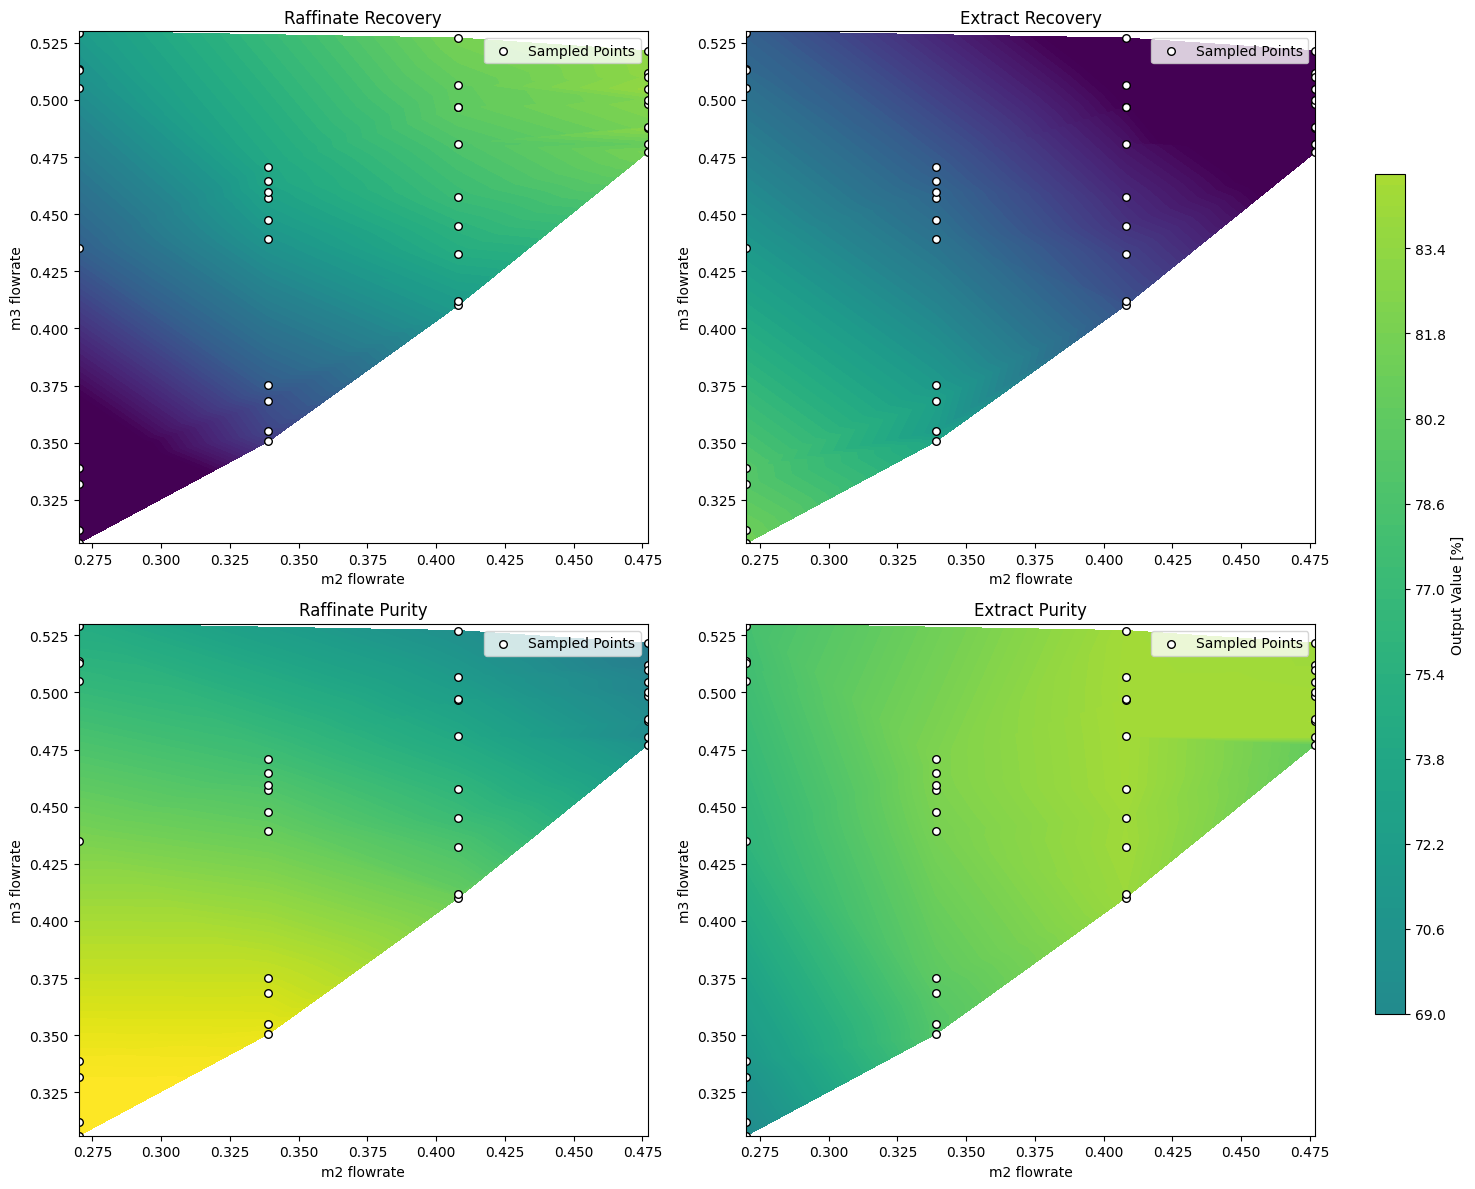

In [73]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri

# # Dummy data for illustration (replace these with your real arrays)
# np.random.seed(0)
# m = 100
# all_initial_inputs = np.random.rand(m, 4) * 10  # m1, m2, m3, m4
all_initial_outputs_plot = all_initial_outputs* 100  # 4 output metrics

# Extract m2 and m3
m2 = all_initial_inputs[:, 1]
m3 = all_initial_inputs[:, 2]

# Create triangulation for irregular (m2, m3) points
triang = tri.Triangulation(m2, m3)

# fig, axes = plt.subplots(2, 2, figsize=(15, 12))
# titles = ['Raffinate Recovery', 'Extract Recovery', 'Raffinate Purity', 'Extract Purity']

# for i, ax in enumerate(axes.flat):
#     tcf = ax.tricontourf(triang, all_initial_outputs[:, i], levels=100, cmap='viridis')
#     ax.set_xlabel('m2 flowrate')
#     ax.set_ylabel('m3 flowrate')
#     ax.set_title(titles[i])
#     plt.colorbar(tcf, ax=ax)

# fig, axes = plt.subplots(2, 2, figsize=(15, 12))
# titles = ['Raffinate Recovery', 'Extract Recovery', 'Raffinate Purity', 'Extract Purity']

# for i, ax in enumerate(axes.flat):
#     tcf = ax.tricontourf(triang, all_initial_outputs_plot[:, i], levels=100, cmap='viridis')
#     ax.scatter(m2, m3, color='white', edgecolor='black', s=30, label='Sampled Points')
#     ax.set_xlabel('m2 flowrate')
#     ax.set_ylabel('m3 flowrate')
#     ax.set_title(titles[i])
#     ax.legend(loc='upper right')
#     plt.colorbar(tcf, ax=ax)

# plt.tight_layout()
# plt.show()

# Define adjustable colorbar limits
vmin, vmax = 50, 90  # User can change these values as needed

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
titles = ['Raffinate Recovery', 'Extract Recovery', 'Raffinate Purity', 'Extract Purity']

# Create a single colorbar axis
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]

# Plotting
for i, ax in enumerate(axes.flat):
    tcf = ax.tricontourf(triang, all_initial_outputs_plot[:, i], levels=100, cmap='viridis', vmin=vmin, vmax=vmax)
    ax.scatter(m2, m3, color='white', edgecolor='black', s=30, label='Sampled Points')
    ax.set_xlabel('m2 flowrate')
    ax.set_ylabel('m3 flowrate')
    ax.set_title(titles[i])
    ax.legend(loc='upper right')

# Add single colorbar
fig.colorbar(tcf, cax=cbar_ax, label='Output Value [%]')

plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space for colorbar
plt.show()



OPTIMIZATION LOOP

In [91]:
constraint_thresholds = [0.995, 0.995] # (Purity constraints) will scale with increased col#

# Note that before hand, we know that:
# (i) We want m1 to be relatively, larger than others
m1_min, m1_max = m_max, m_max*3
# (ii) We want m4 to be relatively, smaller that others
m4_min, m4_max = 0.1, m_min

bounds = [  (m1_min, m1_max), # m1
    (m_min, m_max), # m2
    (m_min, m_max), # m3
    (m4_min, m4_max)  # m4
]

initial_guess = 0 # min
import json
import os

print(f'Optimization Budget: {optimization_budget}')
# Run your function to get the outputs
population_all, f1_vals, f2_vals, c1_vals, c2_vals, all_inputs = constrained_BO(
    optimization_budget, bounds, initial_guess,
    all_initial_inputs, all_initial_outputs,
    constraint_thresholds, 0.001
)



Optimization Budget: 20
c1-size: (5,)
c2-size: (5,)


Starting gen 1
Maxing ECI


[m1, m2, m3, m4]: [0.8612633770261952, 0.27103693131746753, 0.3017512912180793, 0.12357870656555295]
Q_internal: [0.69533367 0.42673216 0.44070971 0.35962655] cm^s/s
Q_internal: [2.5032012  1.53623576 1.58655497 1.29465559] L/h
--------------------------------------------
Q_external: [0.01397756 0.08108316 0.33570712 0.26860151] cm^s/s
Q_external: [0.0503192  0.29189938 1.20854562 0.96696544] L/h
--------------------------------------------
Gen 1 Status:
 | Sampled Inputs:[0.86126338 0.27103693 0.30175129 0.12357871] [m1, m2, m3, m4]|
 Outputs: f1: 0.43173805750024596, f2: 0.8317746001090017 | GPur, FPur: 0.9518073288595552, 0.7557540879367217


Starting gen 2
Maxing ECI


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(




[m1, m2, m3, m4]: [0.9022203417722733, 0.2705449568486668, 0.3012939282283601, 0.23272251608640115]
Q_internal: [0.71397245 0.42650827 0.44050157 0.40929595] cm^s/s
Q_internal: [2.57030082 1.53542976 1.58580567 1.47346542] L/h
--------------------------------------------
Q_external: [0.01399331 0.03120562 0.3046765  0.28746418] cm^s/s
Q_external: [0.05037591 0.11234025 1.0968354  1.03487106] L/h
--------------------------------------------
Gen 2 Status:
 | Sampled Inputs:[0.90222034 0.27054496 0.30129393 0.23272252] [m1, m2, m3, m4]|
 Outputs: f1: 0.25076209049143194, f2: 0.8544972420100511 | GPur, FPur: 0.964737016656059, 0.6816872103065508


Starting gen 3
Maxing ECI


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(




[m1, m2, m3, m4]: [1.4026450613265349, 0.27341607047852545, 0.3057839966423977, 0.1383342225361847]
Q_internal: [0.9417068  0.42781486 0.44254492 0.36634152] cm^s/s
Q_internal: [3.39014448 1.5401335  1.59316173 1.31882949] L/h
--------------------------------------------
Q_external: [0.01473006 0.0762034  0.57536528 0.51389194] cm^s/s
Q_external: [0.05302823 0.27433224 2.071315   1.85001099] L/h
--------------------------------------------
Gen 3 Status:
 | Sampled Inputs:[1.40264506 0.27341607 0.305784   0.13833422] [m1, m2, m3, m4]|
 Outputs: f1: 0.42999783806928915, f2: 0.8693800050396522 | GPur, FPur: 0.9689223645598781, 0.755944401318984


Starting gen 4
Maxing ECI


[m1, m2, m3, m4]: [1.5893012914894045, 0.42294417225515774, 0.47426989818906373, 0.15278894936343082]
Q_internal: [1.02665072 0.49586243 0.51921985 0.37291961] cm^s/s
Q_internal: [3.69594258 1.78510474 1.86919146 1.3425106 ] L/h
--------------------------------------------
Q_external: [0.02335742 0.14630024 0.6537311

/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(




[m1, m2, m3, m4]: [0.530030150944508, 0.2701125041710181, 0.3002536103240287, 0.10005257757325817]
Q_internal: [0.54459534 0.42631147 0.44002814 0.34892023] cm^s/s
Q_internal: [1.96054324 1.53472128 1.58410132 1.25611283] L/h
--------------------------------------------
Q_external: [0.01371668 0.09110791 0.19567511 0.11828388] cm^s/s
Q_external: [0.04938004 0.32798849 0.7044304  0.42582196] L/h
--------------------------------------------
Gen 7 Status:
 | Sampled Inputs:[0.53003015 0.2701125  0.30025361 0.10005258] [m1, m2, m3, m4]|
 Outputs: f1: 0.4591151816051141, f2: 0.6949320729146984 | GPur, FPur: 0.8155260663842746, 0.7541760191685546


Starting gen 8
Maxing ECI


[m1, m2, m3, m4]: [1.3526066140361306, 0.47699998491859563, 0.5299999957332541, 0.26999994553459816]
Q_internal: [0.9189352  0.52046226 0.54458162 0.42626024] cm^s/s
Q_internal: [3.30816671 1.87366414 1.96049383 1.53453687] L/h
--------------------------------------------
Q_external: [0.02411936 0.11832138 0.49267495 

/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(




[m1, m2, m3, m4]: [1.5899957172019756, 0.270000826373943, 0.5299860865008353, 0.10000113757433841]
Q_internal: [1.02696674 0.42626064 0.54457529 0.34889682] cm^s/s
Q_internal: [3.69708025 1.53453832 1.96047105 1.25602856] L/h
--------------------------------------------
Q_external: [0.11831465 0.19567847 0.67806992 0.60070609] cm^s/s
Q_external: [0.42593273 0.70444249 2.4410517  2.16254194] L/h
--------------------------------------------
Gen 13 Status:
 | Sampled Inputs:[1.58999572 0.27000083 0.52998609 0.10000114] [m1, m2, m3, m4]|
 Outputs: f1: 0.7930345590711674, f2: 0.6824111363882811 | GPur, FPur: 0.8012912692208558, 0.8604237600417746


Starting gen 14
Maxing ECI


[m1, m2, m3, m4]: [1.5899994394161527, 0.2700000259103653, 0.30000006883216773, 0.253862055008777]
Q_internal: [1.02696843 0.42626028 0.43991276 0.41891618] cm^s/s
Q_internal: [3.69708635 1.534537   1.58368595 1.50809824] L/h
--------------------------------------------
Q_external: [0.01365248 0.02099659 0.60805225 

In [ ]:

# Convert NumPy arrays to lists before saving
data = {
    "f1_vals": f1_vals.tolist() if isinstance(f1_vals, np.ndarray) else f1_vals,
    "f2_vals": f2_vals.tolist() if isinstance(f2_vals, np.ndarray) else f2_vals,
    "c1_vals": c1_vals.tolist() if isinstance(c1_vals, np.ndarray) else c1_vals,
    "c2_vals": c2_vals.tolist() if isinstance(c2_vals, np.ndarray) else c2_vals,
    "all_inputs": all_inputs.tolist() if isinstance(all_inputs, np.ndarray) else all_inputs,
}

# Save to Google Drive

file_path =f"/content/{optimization_budget}_optimization_results.json"


with open(file_path, "w") as f:
    json.dump(data, f, indent=4)

print(f"File saved at: {file_path}")

from google.colab import files
files.download(f"/content/{optimization_budget}_optimization_results.json")



File saved at: /content/10_optimization_results.json


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import json
import numpy as np

# Load JSON file
file_path = f"/content/{optimization_budget}_optimization_results.json"  # Update path if needed

with open(file_path, "r") as f:
    data = json.load(f)  # Load JSON data into a dictionary

# Convert lists back to NumPy arrays
f1_vals = np.array(data["f1_vals"])
f2_vals = np.array(data["f2_vals"])
c1_vals = np.array(data["c1_vals"])
c2_vals = np.array(data["c2_vals"])
all_inputs = np.array(data["all_inputs"])

# Check shapes of arrays to verify loading
print(f"f1_vals shape: {f1_vals.shape}")
print(f"f2_vals shape: {f2_vals.shape}")
print(f"c1_vals shape: {c1_vals.shape}")
print(f"c2_vals shape: {c2_vals.shape}")
print(f"all_inputs shape: {all_inputs.shape}")


f1_vals shape: (100, 1)
f2_vals shape: (100, 1)
c1_vals shape: (100, 1)
c2_vals shape: (100, 1)
all_inputs shape: (200, 4)


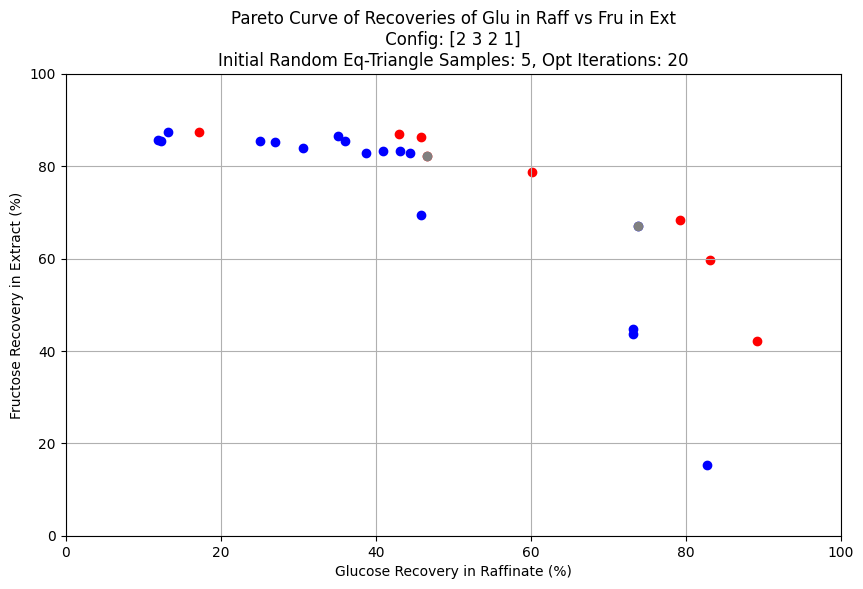

In [92]:
# Plot the Pareto curve
# Convert to percentages
f1_initial = f1_vals[:2 ]* 100
f2_initial = f2_vals[:2] * 100
f1_vals_plot = f1_vals * 100
f2_vals_plot = f2_vals * 100

# Function to find Pareto front
def find_pareto_front(f1, f2):
    pareto_mask = np.ones(len(f1), dtype=bool)  # Start with all points assumed Pareto-optimal

    for i in range(len(f1)):
        if pareto_mask[i]:  # Check only if not already removed
            pareto_mask[i] = not np.any((f1 >= f1[i]) & (f2 >= f2[i]) & ((f1 > f1[i]) | (f2 > f2[i])))

    return pareto_mask

# Identify Pareto-optimal points
pareto_mask = find_pareto_front(f1_vals_plot, f2_vals_plot)

plt.figure(figsize=(10, 6))

# Plot non-Pareto points in blue
plt.scatter(f1_vals_plot[~pareto_mask], f2_vals_plot[~pareto_mask], c='blue', marker='o', label='Optimization Iterations')
# Plot Pareto-optimal points in red
plt.scatter(f1_vals_plot[pareto_mask], f2_vals_plot[pareto_mask], c='red', marker='o', label='Pareto Frontier')

# Plot initial samples in grey
plt.scatter(f1_initial, f2_initial, c='grey', marker='o', label='Initial Samples')

# Labels and formatting
plt.title(f'Pareto Curve of Recoveries of Glu in Raff vs Fru in Ext\n Config: {zone_config} \nInitial Random Eq-Triangle Samples: {sampling_budget}, Opt Iterations: {optimization_budget}')
plt.xlabel('Glucose Recovery in Raffinate (%)')
plt.ylabel('Fructose Recovery in Extract (%)')
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.grid(True)
# plt.legend()
# Save the figure as an image
image_filename = f"{optimization_budget}_Sub_et_al_comparison_pareto.png"
plt.savefig(image_filename, dpi=300, bbox_inches='tight')
plt.show()

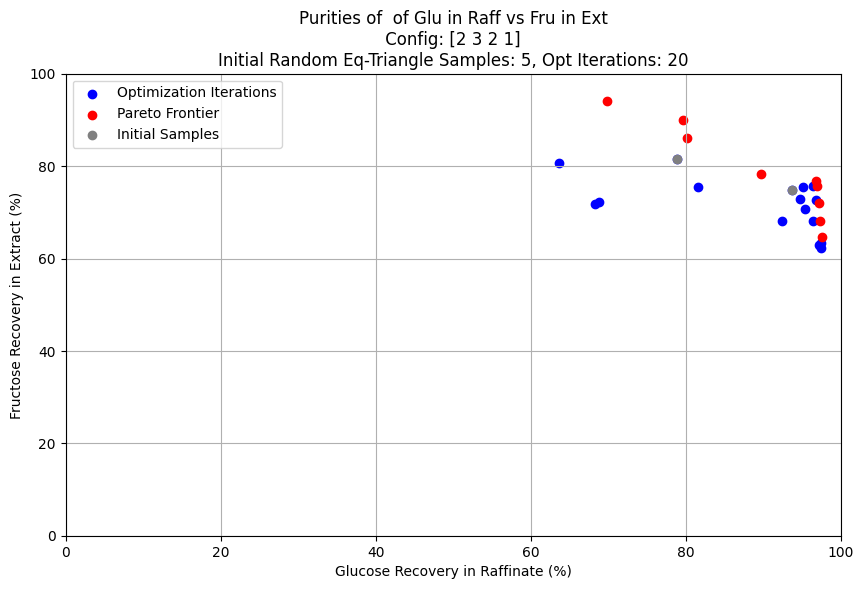

In [93]:
import numpy as np
import matplotlib.pyplot as plt

# Convert to percentages
c1_initial = c1_vals[:2] * 100
c2_initial = c2_vals[:2] * 100
c1_vals_plot = c1_vals * 100
c2_vals_plot = c2_vals * 100

# Function to find Pareto front
def find_pareto_front(c1, c2):
    pareto_mask = np.ones(len(c1), dtype=bool)  # Start with all points assumed Pareto-optimal

    for i in range(len(c1)):
        if pareto_mask[i]:  # Check only if not already removed
            pareto_mask[i] = not np.any((c1 >= c1[i]) & (c2 >= c2[i]) & ((c1 > c1[i]) | (c2 > c2[i])))

    return pareto_mask

# Identify Pareto-optimal points
pareto_mask = find_pareto_front(c1_vals_plot, c2_vals_plot)

plt.figure(figsize=(10, 6))

# Plot non-Pareto points in blue
plt.scatter(c1_vals_plot[~pareto_mask], c2_vals_plot[~pareto_mask], c='blue', marker='o', label='Optimization Iterations')
# Plot Pareto-optimal points in red
plt.scatter(c1_vals_plot[pareto_mask], c2_vals_plot[pareto_mask], c='red', marker='o', label='Pareto Frontier')

# Plot initial samples in grey
plt.scatter(c1_initial, c2_initial, c='grey', marker='o', label='Initial Samples')

# Labels and formatting
plt.title(f'Purities of  of Glu in Raff vs Fru in Ext\n Config: {zone_config} \nInitial Random Eq-Triangle Samples: {sampling_budget}, Opt Iterations: {optimization_budget}')
plt.xlabel('Glucose Recovery in Raffinate (%)')
plt.ylabel('Fructose Recovery in Extract (%)')
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.grid(True)
plt.legend()
# Save the figure as an image
image_filename = "Sub_et_al_comparison_purities_pareto.png"
plt.savefig(image_filename, dpi=300, bbox_inches='tight')
plt.show()


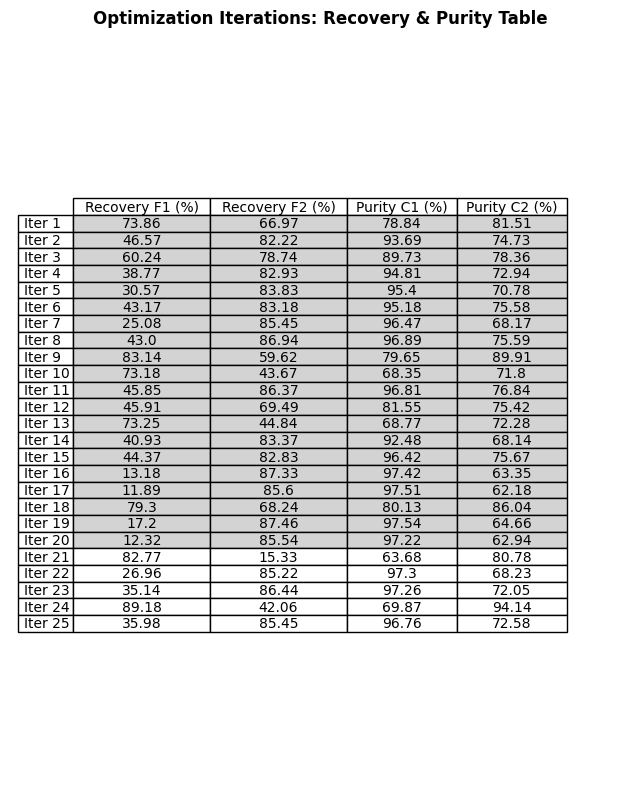

In [94]:
import numpy as np
import matplotlib.pyplot as plt

# Create a data table with recoveries first
data = np.column_stack((f1_vals * 100, f2_vals * 100, c1_vals * 100, c2_vals * 100))
columns = ['Recovery F1 (%)', 'Recovery F2 (%)', 'Purity C1 (%)', 'Purity C2 (%)']
rows = [f'Iter {i+1}' for i in range(len(c1_vals))]

# Identify "star" entries (where f1_vals, f2_vals > 70 and c1_vals, c2_vals > 95)
star_indices = np.where((f1_vals * 100 > 70) & (f2_vals * 100 > 70) &
                        (c1_vals * 100 > 95) & (c2_vals * 100 > 95))[0]

# Identify light pink highlight (recoveries > 70% and purities > 90%)
pink_indices = np.where((f1_vals * 100 > 70) & (f2_vals * 100 > 70) &
                        (c1_vals * 100 > 90) & (c2_vals * 100 > 90))[0]

# Create figure
fig, ax = plt.subplots(figsize=(8, len(c1_vals) * 0.4))
ax.set_title("Optimization Iterations: Recovery & Purity Table", fontsize=12, fontweight='bold', pad=5)
ax.axis('tight')
ax.axis('off')

# Create the table
table = ax.table(cellText=data.round(2),
                 colLabels=columns,
                 rowLabels=rows,
                 cellLoc='center',
                 loc='center')

# Adjust font size
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(columns))))

# Apply colors
for i in range(len(c1_vals)):
    for j in range(len(columns)):
        cell = table[(i+1, j)]  # (row, column) -> +1 because row labels shift index
        if i < 20:
            cell.set_facecolor('lightgray')  # Grey out first 20 rows
        if i in pink_indices:
            cell.set_facecolor('yellow')  # Highlight pink entries (Recoveries >70% & Purities >90%)
        if i in star_indices:
            cell.set_facecolor('lightpink')  # Highlight star entries (Recoveries >70% & Purities >95%)

# Save the figure as an image
image_filename = "optimization_table.png"
fig.savefig(image_filename, dpi=300, bbox_inches='tight')
plt.show()


all_inputs: [[0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 ...
 [0.65047531 0.36259359 0.46279043 0.08117424]
 [1.29879788 0.27003622 0.30021168 0.26991792]
 [1.57320751 0.46952848 0.52988194 0.2466905 ]]
Qj_matrix: [[1.83259571 1.83259571 1.83259571 1.83259571]
 [1.83259571 1.83259571 1.83259571 1.83259571]
 [1.83259571 1.83259571 1.83259571 1.83259571]
 ...
 [3.62068311 2.82932691 3.10475735 2.05573506]
 [5.40285285 2.57489654 2.65784566 2.57457134]
 [6.15717571 3.12327953 3.28918477 2.51072164]]


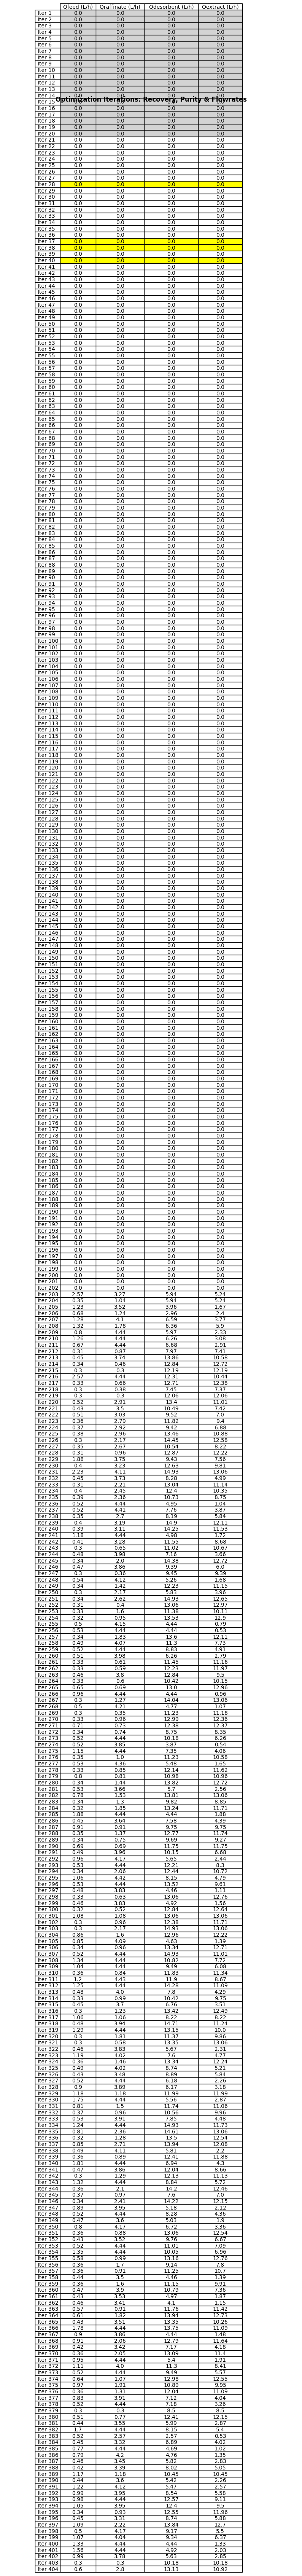

In [ ]:


# Convert mj to Qj
Qj_matrix = mj_to_Qj(all_inputs)
print(f'all_inputs: {all_inputs}')
print(f'Qj_matrix: {Qj_matrix}')
# Calculate external flowrates
Qfeed = Qj_matrix[:, 2] - Qj_matrix[:, 1]
Qraffinate = Qj_matrix[:, 2] - Qj_matrix[:, 3]
Qdesorbent = Qj_matrix[:, 0] - Qj_matrix[:, 3]
Qextract = Qj_matrix[:, 0] - Qj_matrix[:, 1]

# Combine all data for the table
data = np.column_stack(( # f1_vals*100, f2_vals*100, c1_vals*100, c2_vals*100,
                         Qfeed*3.6, Qraffinate*3.6, Qdesorbent*3.6, Qextract*3.6))
columns = [
           'Qfeed (L/h)', 'Qraffinate (L/h)', 'Qdesorbent (L/h)', 'Qextract (L/h)']
rows = [f'Iter {i+1}' for i in range(len(Qraffinate))]

# Identify "star" entries
star_indices = np.where((f1_vals*100 > 70) & (f2_vals*100 > 70) & (c1_vals*100 > 95) & (c2_vals*100 > 95))[0]

# Create figure
fig, ax = plt.subplots(figsize=(10, len(c1_vals) * 0.4))
ax.set_title("Optimization Iterations: Recovery, Purity & Flowrates", fontsize=12, fontweight='bold', pad=5)
ax.axis('tight')
ax.axis('off')

# Create the table
table = ax.table(cellText=data.round(2),
                 colLabels=columns,
                 rowLabels=rows,
                 cellLoc='center',
                 loc='center')

# Adjust font size
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(columns))))

# Apply colors
for i in range(len(c1_vals)):
    for j in range(len(columns)):
        cell = table[(i+1, j)]  # (row, column) -> +1 because row labels shift index
        if i < 20:
            cell.set_facecolor('lightgray')  # Grey out first 20 rows
        if i in star_indices:
            cell.set_facecolor('yellow')  # Highlight star entries in yellow

# Save the figure as an image
image_filename = "optimization_table.png"
fig.savefig(image_filename, dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
from google.colab import files
files.download("optimization_table.png")
files.download("triangle_informed_pareto.png")  # This will prompt a file download

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>